# Import the necessary libraries

In [1]:
import import_ipynb
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import plotly.express as px
from sklearn.feature_selection import f_regression, mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from workalendar.europe import Romania
from sklearn import preprocessing

# Connect to the database

In [2]:
conn = sqlite3.connect('clean_database.db')
cursor = conn.cursor()

# Check all the tables available within the database

In [3]:
cursor.execute("SELECT name FROM sqlite_master WHERE type ='table';")
print(cursor.fetchall())

[('Meteostat_Data',), ('Entsoe_Data',), ('Entsoe_Meteostat_Data',), ('Entsoe_real_data',), ('Entsoe_real_values_and_Meteostat_data',), ('Entsoe_forecasted_data',), ('Entsoe_forecasted_data_and_Meteostat_data',), ('Feature_selected_forecasted_data',), ('Feature_selected_real_data',)]


# Feature Selection

In [4]:
entsoe_meteostat_real = pd.read_sql("SELECT * FROM Entsoe_real_values_and_Meteostat_data;", conn)
entsoe_meteostat_real

timestamp  Biomass  Fossil Brown coal/Lignite  Fossil Gas  \
0      2017-10-02 01:00:00    54.00                    1519.00      509.00   
1      2017-10-02 02:00:00    54.00                    1346.00      476.00   
2      2017-10-02 03:00:00    54.00                    1343.00      473.00   
3      2017-10-02 04:00:00    54.00                    1374.00      475.00   
4      2017-10-02 05:00:00    54.00                    1510.00      483.00   
...                    ...      ...                        ...         ...   
37238  2021-12-31 19:00:00    60.75                     948.00     1299.50   
37239  2021-12-31 20:00:00    63.25                     901.25     1142.00   
37240  2021-12-31 21:00:00    61.75                     926.75     1144.75   
37241  2021-12-31 22:00:00    61.25                     932.25     1148.50   
37242  2021-12-31 23:00:00    58.75                     955.75     1144.50   

       Fossil Hard coal  Hydro Run-of-river and poundage  \
0                 27.00                           720.00   
1                  0.00                           688.00   
2                  0.00                           697.00   
3                  0.00                           739.00   
4                  0.00                           863.00   
...                 ...                              ...   
37238             48.00                          1618.75   
37239             47.50                          1584.75   
37240             49.00                          1608.00   
37241             48.00                          1622.75   
37242             48.75                          1367.00   

       Hydro Water Reservoir  Nuclear  Solar  Wind Onshore  ...  \
0                       0.00  1411.00   0.00         921.0  ...   
1                       0.00  1414.00   0.00         996.0  ...   
2                       0.00  1414.00   0.00         955.0  ...   
3                       0.00  1413.00   0.00         946.0  ...   
4                       0.00  1414.00   0.00         952.0  ...   
...                      ...      ...    ...           ...  ...   
37238                 425.25  1404.50   0.00        1305.0  ...   
37239                 385.75  1410.50   0.00        1271.0  ...   
37240                 330.25  1413.00   0.00        1077.0  ...   
37241                 305.50  1415.00   0.75        1101.5  ...   
37242                 230.00  1416.75   0.00        1100.0  ...   

       avg_wind_speed_AB (km/h)  avg_wind_speed_B (km/h)  \
0                           3.6                      3.6   
1                           3.6                      3.6   
2                           3.6                      3.6   
3                           3.6                      3.6   
4                           3.6                      0.0   
...                         ...                      ...   
37238                      12.6                      9.0   
37239                      12.6                     11.0   
37240                      12.6                     11.0   
37241                      12.6                      9.0   
37242                      12.6                      7.0   

       avg_sea-lvl_air_pres_NT (hPa)  avg_sea-lvl_air_pres_GL (hPa)  \
0                             1030.1                         1028.7   
1                             1030.1                         1028.5   
2                             1030.0                         1028.6   
3                             1030.0                         1028.8   
4                             1030.2                         1029.1   
...                              ...                            ...   
37238                         1016.8                         1018.1   
37239                         1016.3                         1017.6   
37240                         1016.4                         1017.3   
37241                         1015.9                         1016.8   
37242                         1015.9                

> First, I will try to restrict the number of features (for example the sum between all the energy produced by the power plants at a certain period of time result in the total energy produced in that interval) in then look if there is any correlation between the remaining features

### Reducing the number of features (where that is possible)

In [5]:
entsoe_meteostat_real_1 = entsoe_meteostat_real.copy()
entsoe_meteostat_real_1

timestamp  Biomass  Fossil Brown coal/Lignite  Fossil Gas  \
0      2017-10-02 01:00:00    54.00                    1519.00      509.00   
1      2017-10-02 02:00:00    54.00                    1346.00      476.00   
2      2017-10-02 03:00:00    54.00                    1343.00      473.00   
3      2017-10-02 04:00:00    54.00                    1374.00      475.00   
4      2017-10-02 05:00:00    54.00                    1510.00      483.00   
...                    ...      ...                        ...         ...   
37238  2021-12-31 19:00:00    60.75                     948.00     1299.50   
37239  2021-12-31 20:00:00    63.25                     901.25     1142.00   
37240  2021-12-31 21:00:00    61.75                     926.75     1144.75   
37241  2021-12-31 22:00:00    61.25                     932.25     1148.50   
37242  2021-12-31 23:00:00    58.75                     955.75     1144.50   

       Fossil Hard coal  Hydro Run-of-river and poundage  \
0                 27.00                           720.00   
1                  0.00                           688.00   
2                  0.00                           697.00   
3                  0.00                           739.00   
4                  0.00                           863.00   
...                 ...                              ...   
37238             48.00                          1618.75   
37239             47.50                          1584.75   
37240             49.00                          1608.00   
37241             48.00                          1622.75   
37242             48.75                          1367.00   

       Hydro Water Reservoir  Nuclear  Solar  Wind Onshore  ...  \
0                       0.00  1411.00   0.00         921.0  ...   
1                       0.00  1414.00   0.00         996.0  ...   
2                       0.00  1414.00   0.00         955.0  ...   
3                       0.00  1413.00   0.00         946.0  ...   
4                       0.00  1414.00   0.00         952.0  ...   
...                      ...      ...    ...           ...  ...   
37238                 425.25  1404.50   0.00        1305.0  ...   
37239                 385.75  1410.50   0.00        1271.0  ...   
37240                 330.25  1413.00   0.00        1077.0  ...   
37241                 305.50  1415.00   0.75        1101.5  ...   
37242                 230.00  1416.75   0.00        1100.0  ...   

       avg_wind_speed_AB (km/h)  avg_wind_speed_B (km/h)  \
0                           3.6                      3.6   
1                           3.6                      3.6   
2                           3.6                      3.6   
3                           3.6                      3.6   
4                           3.6                      0.0   
...                         ...                      ...   
37238                      12.6                      9.0   
37239                      12.6                     11.0   
37240                      12.6                     11.0   
37241                      12.6                      9.0   
37242                      12.6                      7.0   

       avg_sea-lvl_air_pres_NT (hPa)  avg_sea-lvl_air_pres_GL (hPa)  \
0                             1030.1                         1028.7   
1                             1030.1                         1028.5   
2                             1030.0                         1028.6   
3                             1030.0                         1028.8   
4                             1030.2                         1029.1   
...                              ...                            ...   
37238                         1016.8                         1018.1   
37239                         1016.3                         1017.6   
37240                         1016.4                         1017.3   
37241                         1015.9                         1016.8   
37242                         1015.9                

In [6]:
entsoe_meteostat_real_1 = entsoe_meteostat_real_1.rename(columns={"real_load": "real_energy_load"})

In [7]:
try:
    entsoe_meteostat_real_1 = entsoe_meteostat_real_1.reset_index()
    entsoe_meteostat_real_1.set_index('timestamp', inplace = True)
    entsoe_meteostat_real_1.drop('index', axis=1, inplace=True)
except:
    pass

In [8]:
entsoe_meteostat_real_1

Biomass  Fossil Brown coal/Lignite  Fossil Gas  \
timestamp                                                             
2017-10-02 01:00:00    54.00                    1519.00      509.00   
2017-10-02 02:00:00    54.00                    1346.00      476.00   
2017-10-02 03:00:00    54.00                    1343.00      473.00   
2017-10-02 04:00:00    54.00                    1374.00      475.00   
2017-10-02 05:00:00    54.00                    1510.00      483.00   
...                      ...                        ...         ...   
2021-12-31 19:00:00    60.75                     948.00     1299.50   
2021-12-31 20:00:00    63.25                     901.25     1142.00   
2021-12-31 21:00:00    61.75                     926.75     1144.75   
2021-12-31 22:00:00    61.25                     932.25     1148.50   
2021-12-31 23:00:00    58.75                     955.75     1144.50   

                     Fossil Hard coal  Hydro Run-of-river and poundage  \
timestamp                                                                
2017-10-02 01:00:00             27.00                           720.00   
2017-10-02 02:00:00              0.00                           688.00   
2017-10-02 03:00:00              0.00                           697.00   
2017-10-02 04:00:00              0.00                           739.00   
2017-10-02 05:00:00              0.00                           863.00   
...                               ...                              ...   
2021-12-31 19:00:00             48.00                          1618.75   
2021-12-31 20:00:00             47.50                          1584.75   
2021-12-31 21:00:00             49.00                          1608.00   
2021-12-31 22:00:00             48.00                          1622.75   
2021-12-31 23:00:00             48.75                          1367.00   

                     Hydro Water Reservoir  Nuclear  Solar  Wind Onshore  \
timestamp                                                                  
2017-10-02 01:00:00                   0.00  1411.00   0.00         921.0   
2017-10-02 02:00:00                   0.00  1414.00   0.00         996.0   
2017-10-02 03:00:00                   0.00  1414.00   0.00         955.0   
2017-10-02 04:00:00                   0.00  1413.00   0.00         946.0   
2017-10-02 05:00:00                   0.00  1414.00   0.00         952.0   
...                                    ...      ...    ...           ...   
2021-12-31 19:00:00                 425.25  1404.50   0.00        1305.0   
2021-12-31 20:00:00                 385.75  1410.50   0.00        1271.0   
2021-12-31 21:00:00                 330.25  1413.00   0.00        1077.0   
2021-12-31 22:00:00                 305.50  1415.00   0.75        1101.5   
2021-12-31 23:00:00                 230.00  1416.75   0.00        1100.0   

                     real_exchange_BG_RO  ...  avg_wind_speed_AB (km/h)  \
timestamp                                 ...                             
2017-10-02 01:00:00                  0.0  ...                       3.6   
2017-10-02 02:00:00                  0.0  ...                       3.6   
2017-10-02 03:00:00                  0.0  ...                       3.6   
2017-10-02 04:00:00                  0.0  ...                       3.6   
2017-10-02 05:00:00                  0.0  ...                       3.6   
...                                  ...  ...                       ...   
2021-12-31 19:00:00                228.0  ...                      12.6   
2021-12-31 20:00:00                152.0  ...                      12.6   
2021-12-31 21:00:00                166.0  ...                      12.6   
2021-12-31 22:00:00                182.0  ...                      12.6   
2021-12-31 23:00:00                193.0  ...                      12.6   

                     avg_wind_speed_B (km/h)  avg_sea-lvl_air_pres_NT (hPa)  \
timestamp                                                                     
2017-10-02 

In [9]:
entsoe_meteostat_real_1.columns

Index(['Biomass', 'Fossil Brown coal/Lignite', 'Fossil Gas',
       'Fossil Hard coal', 'Hydro Run-of-river and poundage',
       'Hydro Water Reservoir', 'Nuclear', 'Solar', 'Wind Onshore',
       'real_exchange_BG_RO', 'real_exchange_HU_RO', 'real_exchange_RS_RO',
       'real_exchange_UA_RO', 'real_exchange_RO_BG', 'real_exchange_RO_HU',
       'real_exchange_RO_RS', 'real_exchange_RO_UA', 'real_energy_load',
       'air_temp_NT (°C)', 'air_temp_GL (°C)', 'air_temp_CL (°C)',
       'air_temp_DJ (°C)', 'air_temp_TM (°C)', 'air_temp_CJ (°C)',
       'air_temp_AB (°C)', 'air_temp_B (°C)', 'dew_point_NT (°C)',
       'dew_point_GL (°C)', 'dew_point_CL (°C)', 'dew_point_DJ (°C)',
       'dew_point_TM (°C)', 'dew_point_CJ (°C)', 'dew_point_AB (°C)',
       'dew_point_B (°C)', 'rel_humidity_NT (%)', 'rel_humidity_GL (%)',
       'rel_humidity_CL (%)', 'rel_humidity_DJ (%)', 'rel_humidity_TM (%)',
       'rel_humidity_CJ (%)', 'rel_humidity_AB (%)', 'rel_humidity_B (%)',
       'avg_wind_di

In [10]:
# I put the real_load column at the end of the table to be easier to be found or seen
entsoe_meteostat_real_1 = entsoe_meteostat_real_1[['Biomass', 'Fossil Brown coal/Lignite', 'Fossil Gas',
       'Fossil Hard coal', 'Hydro Run-of-river and poundage',
       'Hydro Water Reservoir', 'Nuclear', 'Solar', 'Wind Onshore',
       'real_exchange_BG_RO', 'real_exchange_HU_RO', 'real_exchange_RS_RO',
       'real_exchange_UA_RO', 'real_exchange_RO_BG', 'real_exchange_RO_HU',
       'real_exchange_RO_RS', 'real_exchange_RO_UA','air_temp_NT (°C)', 
       'air_temp_GL (°C)', 'air_temp_CL (°C)',
       'air_temp_DJ (°C)', 'air_temp_TM (°C)', 'air_temp_CJ (°C)',
       'air_temp_AB (°C)', 'air_temp_B (°C)', 'dew_point_NT (°C)',
       'dew_point_GL (°C)', 'dew_point_CL (°C)', 'dew_point_DJ (°C)',
       'dew_point_TM (°C)', 'dew_point_CJ (°C)', 'dew_point_AB (°C)',
       'dew_point_B (°C)', 'rel_humidity_NT (%)', 'rel_humidity_GL (%)',
       'rel_humidity_CL (%)', 'rel_humidity_DJ (%)', 'rel_humidity_TM (%)',
       'rel_humidity_CJ (%)', 'rel_humidity_AB (%)', 'rel_humidity_B (%)',
       'avg_wind_dir_NT (°)', 'avg_wind_dir_GL (°)', 'avg_wind_dir_CL (°)',
       'avg_wind_dir_DJ (°)', 'avg_wind_dir_TM (°)', 'avg_wind_dir_CJ (°)',
       'avg_wind_dir_AB (°)', 'avg_wind_dir_B (°)', 'avg_wind_speed_NT (km/h)',
       'avg_wind_speed_GL (km/h)', 'avg_wind_speed_CL (km/h)',
       'avg_wind_speed_DJ (km/h)', 'avg_wind_speed_TM (km/h)',
       'avg_wind_speed_CJ (km/h)', 'avg_wind_speed_AB (km/h)',
       'avg_wind_speed_B (km/h)', 'avg_sea-lvl_air_pres_NT (hPa)',
       'avg_sea-lvl_air_pres_GL (hPa)', 'avg_sea-lvl_air_pres_CL (hPa)',
       'avg_sea-lvl_air_pres_DJ (hPa)', 'avg_sea-lvl_air_pres_TM (hPa)',
       'avg_sea-lvl_air_pres_CJ (hPa)', 'avg_sea-lvl_air_pres_AB (hPa)',
       'avg_sea-lvl_air_pres_B (hPa)', 'real_energy_load']]

In [11]:
entsoe_meteostat_real_1

Biomass  Fossil Brown coal/Lignite  Fossil Gas  \
timestamp                                                             
2017-10-02 01:00:00    54.00                    1519.00      509.00   
2017-10-02 02:00:00    54.00                    1346.00      476.00   
2017-10-02 03:00:00    54.00                    1343.00      473.00   
2017-10-02 04:00:00    54.00                    1374.00      475.00   
2017-10-02 05:00:00    54.00                    1510.00      483.00   
...                      ...                        ...         ...   
2021-12-31 19:00:00    60.75                     948.00     1299.50   
2021-12-31 20:00:00    63.25                     901.25     1142.00   
2021-12-31 21:00:00    61.75                     926.75     1144.75   
2021-12-31 22:00:00    61.25                     932.25     1148.50   
2021-12-31 23:00:00    58.75                     955.75     1144.50   

                     Fossil Hard coal  Hydro Run-of-river and poundage  \
timestamp                                                                
2017-10-02 01:00:00             27.00                           720.00   
2017-10-02 02:00:00              0.00                           688.00   
2017-10-02 03:00:00              0.00                           697.00   
2017-10-02 04:00:00              0.00                           739.00   
2017-10-02 05:00:00              0.00                           863.00   
...                               ...                              ...   
2021-12-31 19:00:00             48.00                          1618.75   
2021-12-31 20:00:00             47.50                          1584.75   
2021-12-31 21:00:00             49.00                          1608.00   
2021-12-31 22:00:00             48.00                          1622.75   
2021-12-31 23:00:00             48.75                          1367.00   

                     Hydro Water Reservoir  Nuclear  Solar  Wind Onshore  \
timestamp                                                                  
2017-10-02 01:00:00                   0.00  1411.00   0.00         921.0   
2017-10-02 02:00:00                   0.00  1414.00   0.00         996.0   
2017-10-02 03:00:00                   0.00  1414.00   0.00         955.0   
2017-10-02 04:00:00                   0.00  1413.00   0.00         946.0   
2017-10-02 05:00:00                   0.00  1414.00   0.00         952.0   
...                                    ...      ...    ...           ...   
2021-12-31 19:00:00                 425.25  1404.50   0.00        1305.0   
2021-12-31 20:00:00                 385.75  1410.50   0.00        1271.0   
2021-12-31 21:00:00                 330.25  1413.00   0.00        1077.0   
2021-12-31 22:00:00                 305.50  1415.00   0.75        1101.5   
2021-12-31 23:00:00                 230.00  1416.75   0.00        1100.0   

                     real_exchange_BG_RO  ...  avg_wind_speed_B (km/h)  \
timestamp                                 ...                            
2017-10-02 01:00:00                  0.0  ...                      3.6   
2017-10-02 02:00:00                  0.0  ...                      3.6   
2017-10-02 03:00:00                  0.0  ...                      3.6   
2017-10-02 04:00:00                  0.0  ...                      3.6   
2017-10-02 05:00:00                  0.0  ...                      0.0   
...                                  ...  ...                      ...   
2021-12-31 19:00:00                228.0  ...                      9.0   
2021-12-31 20:00:00                152.0  ...                     11.0   
2021-12-31 21:00:00                166.0  ...                     11.0   
2021-12-31 22:00:00                182.0  ...                      9.0   
2021-12-31 23:00:00                193.0  ...                      7.0   

                     avg_sea-lvl_air_pres_NT (hPa)  \
timestamp                                            
2017-10-02 01:00:00                         1030.1   
2017-10-02 02:00:00 

In [12]:
column_list = entsoe_meteostat_real_1.loc[:, : "Wind Onshore"].columns
column_list

Index(['Biomass', 'Fossil Brown coal/Lignite', 'Fossil Gas',
       'Fossil Hard coal', 'Hydro Run-of-river and poundage',
       'Hydro Water Reservoir', 'Nuclear', 'Solar', 'Wind Onshore'],
      dtype='object')

In [13]:
entsoe_meteostat_real_1["real_energy_produced"] = entsoe_meteostat_real_1[column_list].sum(axis = 1).copy()

C:\Users\Elena\AppData\Local\Temp/ipykernel_5116/3628763763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entsoe_meteostat_real_1["real_energy_produced"] = entsoe_meteostat_real_1[column_list].sum(axis = 1).copy()


In [14]:
def delete_columns(df, col_list):
    try:
        for i in col_list:
            df = df.drop([i], axis = 1)
    except:
        print("You allready deleted the columns !")
        pass
    return df

In [15]:
entsoe_meteostat_real_1 = delete_columns(entsoe_meteostat_real_1, column_list)
entsoe_meteostat_real_1

real_exchange_BG_RO  real_exchange_HU_RO  \
timestamp                                                       
2017-10-02 01:00:00                  0.0               265.00   
2017-10-02 02:00:00                  0.0               311.00   
2017-10-02 03:00:00                  0.0               327.00   
2017-10-02 04:00:00                  0.0               341.00   
2017-10-02 05:00:00                  0.0               340.00   
...                                  ...                  ...   
2021-12-31 19:00:00                228.0               288.00   
2021-12-31 20:00:00                152.0               326.75   
2021-12-31 21:00:00                166.0               297.75   
2021-12-31 22:00:00                182.0               261.00   
2021-12-31 23:00:00                193.0               306.00   

                     real_exchange_RS_RO  real_exchange_UA_RO  \
timestamp                                                       
2017-10-02 01:00:00                 95.0                329.0   
2017-10-02 02:00:00                 52.0                337.0   
2017-10-02 03:00:00                  0.0                332.0   
2017-10-02 04:00:00                  0.0                340.0   
2017-10-02 05:00:00                  0.0                357.0   
...                                  ...                  ...   
2021-12-31 19:00:00                  0.0                428.0   
2021-12-31 20:00:00                  0.0                434.0   
2021-12-31 21:00:00                  0.0                377.0   
2021-12-31 22:00:00                  0.0                248.0   
2021-12-31 23:00:00                  0.0                249.0   

                     real_exchange_RO_BG  real_exchange_RO_HU  \
timestamp                                                       
2017-10-02 01:00:00                546.0                  0.0   
2017-10-02 02:00:00                451.0                  0.0   
2017-10-02 03:00:00                376.0                  0.0   
2017-10-02 04:00:00                366.0                  0.0   
2017-10-02 05:00:00                335.0                  0.0   
...                                  ...                  ...   
2021-12-31 19:00:00                223.0                  0.0   
2021-12-31 20:00:00                220.0                  0.0   
2021-12-31 21:00:00                151.0                  0.0   
2021-12-31 22:00:00                202.0                  0.0   
2021-12-31 23:00:00                214.0                  0.0   

                     real_exchange_RO_RS  real_exchange_RO_UA  \
timestamp                                                       
2017-10-02 01:00:00                  0.0                  0.0   
2017-10-02 02:00:00                  0.0                  0.0   
2017-10-02 03:00:00                  7.0                  0.0   
2017-10-02 04:00:00                 18.0                  0.0   
2017-10-02 05:00:00                 67.0                  0.0   
...                                  ...                  ...   
2021-12-31 19:00:00                245.0                  0.0   
2021-12-31 20:00:00                265.0                  0.0   
2021-12-31 21:00:00                452.0                  0.0   
2021-12-31 22:00:00                564.0                  0.0   
2021-12-31 23:00:00                492.0                  0.0   

                     air_temp_NT (°C)  air_temp_GL (°C)  ...  \
timestamp                                                ...   
2017-10-02 01:00:00               4.7               6.0  ...   
2017-10-02 02:00:00               3.7               6.4  ...   
2017-10-02 03:00:00               3.2               5.8  ...   
2017-10-02 04:00:00               3.5               5.0  ...   
2017-10-02 05:00:00               3.1               4.6  ...   
...                               ...               ...  ...   
2021-12-31 19:00:00               7.4               1.4  ...   
2021-12-31 20:00:00               7.3               0.4  ... 

In [16]:
column_list_2 = entsoe_meteostat_real_1.iloc[:, :4].columns
column_list_2

Index(['real_exchange_BG_RO', 'real_exchange_HU_RO', 'real_exchange_RS_RO',
       'real_exchange_UA_RO'],
      dtype='object')

In [17]:
entsoe_meteostat_real_1["imported_real_energy"] = entsoe_meteostat_real_1[column_list_2].sum(axis = 1).copy()
entsoe_meteostat_real_1

real_exchange_BG_RO  real_exchange_HU_RO  \
timestamp                                                       
2017-10-02 01:00:00                  0.0               265.00   
2017-10-02 02:00:00                  0.0               311.00   
2017-10-02 03:00:00                  0.0               327.00   
2017-10-02 04:00:00                  0.0               341.00   
2017-10-02 05:00:00                  0.0               340.00   
...                                  ...                  ...   
2021-12-31 19:00:00                228.0               288.00   
2021-12-31 20:00:00                152.0               326.75   
2021-12-31 21:00:00                166.0               297.75   
2021-12-31 22:00:00                182.0               261.00   
2021-12-31 23:00:00                193.0               306.00   

                     real_exchange_RS_RO  real_exchange_UA_RO  \
timestamp                                                       
2017-10-02 01:00:00                 95.0                329.0   
2017-10-02 02:00:00                 52.0                337.0   
2017-10-02 03:00:00                  0.0                332.0   
2017-10-02 04:00:00                  0.0                340.0   
2017-10-02 05:00:00                  0.0                357.0   
...                                  ...                  ...   
2021-12-31 19:00:00                  0.0                428.0   
2021-12-31 20:00:00                  0.0                434.0   
2021-12-31 21:00:00                  0.0                377.0   
2021-12-31 22:00:00                  0.0                248.0   
2021-12-31 23:00:00                  0.0                249.0   

                     real_exchange_RO_BG  real_exchange_RO_HU  \
timestamp                                                       
2017-10-02 01:00:00                546.0                  0.0   
2017-10-02 02:00:00                451.0                  0.0   
2017-10-02 03:00:00                376.0                  0.0   
2017-10-02 04:00:00                366.0                  0.0   
2017-10-02 05:00:00                335.0                  0.0   
...                                  ...                  ...   
2021-12-31 19:00:00                223.0                  0.0   
2021-12-31 20:00:00                220.0                  0.0   
2021-12-31 21:00:00                151.0                  0.0   
2021-12-31 22:00:00                202.0                  0.0   
2021-12-31 23:00:00                214.0                  0.0   

                     real_exchange_RO_RS  real_exchange_RO_UA  \
timestamp                                                       
2017-10-02 01:00:00                  0.0                  0.0   
2017-10-02 02:00:00                  0.0                  0.0   
2017-10-02 03:00:00                  7.0                  0.0   
2017-10-02 04:00:00                 18.0                  0.0   
2017-10-02 05:00:00                 67.0                  0.0   
...                                  ...                  ...   
2021-12-31 19:00:00                245.0                  0.0   
2021-12-31 20:00:00                265.0                  0.0   
2021-12-31 21:00:00                452.0                  0.0   
2021-12-31 22:00:00                564.0                  0.0   
2021-12-31 23:00:00                492.0                  0.0   

                     air_temp_NT (°C)  air_temp_GL (°C)  ...  \
timestamp                                                ...   
2017-10-02 01:00:00               4.7               6.0  ...   
2017-10-02 02:00:00               3.7               6.4  ...   
2017-10-02 03:00:00               3.2               5.8  ...   
2017-10-02 04:00:00               3.5               5.0  ...   
2017-10-02 05:00:00               3.1               4.6  ...   
...                               ...               ...  ...   
2021-12-31 19:00:00               7.4               1.4  ...   
2021-12-31 20:00:00               7.3               0.4  ... 

In [18]:
entsoe_meteostat_real_1 = delete_columns(entsoe_meteostat_real_1, column_list_2)
entsoe_meteostat_real_1

real_exchange_RO_BG  real_exchange_RO_HU  \
timestamp                                                       
2017-10-02 01:00:00                546.0                  0.0   
2017-10-02 02:00:00                451.0                  0.0   
2017-10-02 03:00:00                376.0                  0.0   
2017-10-02 04:00:00                366.0                  0.0   
2017-10-02 05:00:00                335.0                  0.0   
...                                  ...                  ...   
2021-12-31 19:00:00                223.0                  0.0   
2021-12-31 20:00:00                220.0                  0.0   
2021-12-31 21:00:00                151.0                  0.0   
2021-12-31 22:00:00                202.0                  0.0   
2021-12-31 23:00:00                214.0                  0.0   

                     real_exchange_RO_RS  real_exchange_RO_UA  \
timestamp                                                       
2017-10-02 01:00:00                  0.0                  0.0   
2017-10-02 02:00:00                  0.0                  0.0   
2017-10-02 03:00:00                  7.0                  0.0   
2017-10-02 04:00:00                 18.0                  0.0   
2017-10-02 05:00:00                 67.0                  0.0   
...                                  ...                  ...   
2021-12-31 19:00:00                245.0                  0.0   
2021-12-31 20:00:00                265.0                  0.0   
2021-12-31 21:00:00                452.0                  0.0   
2021-12-31 22:00:00                564.0                  0.0   
2021-12-31 23:00:00                492.0                  0.0   

                     air_temp_NT (°C)  air_temp_GL (°C)  air_temp_CL (°C)  \
timestamp                                                                   
2017-10-02 01:00:00               4.7               6.0               3.0   
2017-10-02 02:00:00               3.7               6.4               2.6   
2017-10-02 03:00:00               3.2               5.8               3.5   
2017-10-02 04:00:00               3.5               5.0               3.2   
2017-10-02 05:00:00               3.1               4.6               4.0   
...                               ...               ...               ...   
2021-12-31 19:00:00               7.4               1.4               4.4   
2021-12-31 20:00:00               7.3               0.4               4.6   
2021-12-31 21:00:00               7.0               1.6               4.9   
2021-12-31 22:00:00               7.5               2.1               5.2   
2021-12-31 23:00:00               7.6               2.4               5.5   

                     air_temp_DJ (°C)  air_temp_TM (°C)  air_temp_CJ (°C)  \
timestamp                                                                   
2017-10-02 01:00:00               6.7               6.2               2.4   
2017-10-02 02:00:00               6.1               6.2               1.4   
2017-10-02 03:00:00               5.3               6.0               1.4   
2017-10-02 04:00:00               5.0               6.0               1.3   
2017-10-02 05:00:00               5.1               6.2               0.5   
...                               ...               ...               ...   
2021-12-31 19:00:00               6.0               4.0               4.2   
2021-12-31 20:00:00               5.0               3.2               4.3   
2021-12-31 21:00:00               5.0               2.1               4.3   
2021-12-31 22:00:00               5.0               1.5               4.2   
2021-12-31 23:00:00               5.0               1.8               4.2   

                     ...  avg_sea-lvl_air_pres_GL (hPa)  \
timestamp            ...                                  
2017-10-02 01:00:00  ...                         1028.7   
2017-10-02 02:00:00  ...                         1028.5   
2017-10-02 03:00:00  ...                         1028.6   
2017-10-02 04:00:00  ...      

In [19]:
column_list_3 = entsoe_meteostat_real_1.iloc[:, :4].columns
column_list_3

Index(['real_exchange_RO_BG', 'real_exchange_RO_HU', 'real_exchange_RO_RS',
       'real_exchange_RO_UA'],
      dtype='object')

In [20]:
entsoe_meteostat_real_1["exported_real_energy"] = entsoe_meteostat_real_1[column_list_3].sum(axis = 1).copy()
entsoe_meteostat_real_1

real_exchange_RO_BG  real_exchange_RO_HU  \
timestamp                                                       
2017-10-02 01:00:00                546.0                  0.0   
2017-10-02 02:00:00                451.0                  0.0   
2017-10-02 03:00:00                376.0                  0.0   
2017-10-02 04:00:00                366.0                  0.0   
2017-10-02 05:00:00                335.0                  0.0   
...                                  ...                  ...   
2021-12-31 19:00:00                223.0                  0.0   
2021-12-31 20:00:00                220.0                  0.0   
2021-12-31 21:00:00                151.0                  0.0   
2021-12-31 22:00:00                202.0                  0.0   
2021-12-31 23:00:00                214.0                  0.0   

                     real_exchange_RO_RS  real_exchange_RO_UA  \
timestamp                                                       
2017-10-02 01:00:00                  0.0                  0.0   
2017-10-02 02:00:00                  0.0                  0.0   
2017-10-02 03:00:00                  7.0                  0.0   
2017-10-02 04:00:00                 18.0                  0.0   
2017-10-02 05:00:00                 67.0                  0.0   
...                                  ...                  ...   
2021-12-31 19:00:00                245.0                  0.0   
2021-12-31 20:00:00                265.0                  0.0   
2021-12-31 21:00:00                452.0                  0.0   
2021-12-31 22:00:00                564.0                  0.0   
2021-12-31 23:00:00                492.0                  0.0   

                     air_temp_NT (°C)  air_temp_GL (°C)  air_temp_CL (°C)  \
timestamp                                                                   
2017-10-02 01:00:00               4.7               6.0               3.0   
2017-10-02 02:00:00               3.7               6.4               2.6   
2017-10-02 03:00:00               3.2               5.8               3.5   
2017-10-02 04:00:00               3.5               5.0               3.2   
2017-10-02 05:00:00               3.1               4.6               4.0   
...                               ...               ...               ...   
2021-12-31 19:00:00               7.4               1.4               4.4   
2021-12-31 20:00:00               7.3               0.4               4.6   
2021-12-31 21:00:00               7.0               1.6               4.9   
2021-12-31 22:00:00               7.5               2.1               5.2   
2021-12-31 23:00:00               7.6               2.4               5.5   

                     air_temp_DJ (°C)  air_temp_TM (°C)  air_temp_CJ (°C)  \
timestamp                                                                   
2017-10-02 01:00:00               6.7               6.2               2.4   
2017-10-02 02:00:00               6.1               6.2               1.4   
2017-10-02 03:00:00               5.3               6.0               1.4   
2017-10-02 04:00:00               5.0               6.0               1.3   
2017-10-02 05:00:00               5.1               6.2               0.5   
...                               ...               ...               ...   
2021-12-31 19:00:00               6.0               4.0               4.2   
2021-12-31 20:00:00               5.0               3.2               4.3   
2021-12-31 21:00:00               5.0               2.1               4.3   
2021-12-31 22:00:00               5.0               1.5               4.2   
2021-12-31 23:00:00               5.0               1.8               4.2   

                     ...  avg_sea-lvl_air_pres_CL (hPa)  \
timestamp            ...                                  
2017-10-02 01:00:00  ...                         1028.0   
2017-10-02 02:00:00  ...                         1028.2   
2017-10-02 03:00:00  ...                         1028.2   
2017-10-02 04:00:00  ...      

In [21]:
entsoe_meteostat_real_1 = delete_columns(entsoe_meteostat_real_1, column_list_3)
entsoe_meteostat_real_1

air_temp_NT (°C)  air_temp_GL (°C)  air_temp_CL (°C)  \
timestamp                                                                   
2017-10-02 01:00:00               4.7               6.0               3.0   
2017-10-02 02:00:00               3.7               6.4               2.6   
2017-10-02 03:00:00               3.2               5.8               3.5   
2017-10-02 04:00:00               3.5               5.0               3.2   
2017-10-02 05:00:00               3.1               4.6               4.0   
...                               ...               ...               ...   
2021-12-31 19:00:00               7.4               1.4               4.4   
2021-12-31 20:00:00               7.3               0.4               4.6   
2021-12-31 21:00:00               7.0               1.6               4.9   
2021-12-31 22:00:00               7.5               2.1               5.2   
2021-12-31 23:00:00               7.6               2.4               5.5   

                     air_temp_DJ (°C)  air_temp_TM (°C)  air_temp_CJ (°C)  \
timestamp                                                                   
2017-10-02 01:00:00               6.7               6.2               2.4   
2017-10-02 02:00:00               6.1               6.2               1.4   
2017-10-02 03:00:00               5.3               6.0               1.4   
2017-10-02 04:00:00               5.0               6.0               1.3   
2017-10-02 05:00:00               5.1               6.2               0.5   
...                               ...               ...               ...   
2021-12-31 19:00:00               6.0               4.0               4.2   
2021-12-31 20:00:00               5.0               3.2               4.3   
2021-12-31 21:00:00               5.0               2.1               4.3   
2021-12-31 22:00:00               5.0               1.5               4.2   
2021-12-31 23:00:00               5.0               1.8               4.2   

                     air_temp_AB (°C)  air_temp_B (°C)  dew_point_NT (°C)  \
timestamp                                                                   
2017-10-02 01:00:00               2.9              3.6                2.6   
2017-10-02 02:00:00               3.2              4.6                2.1   
2017-10-02 03:00:00               2.8              2.6                1.6   
2017-10-02 04:00:00               0.9              1.2                1.9   
2017-10-02 05:00:00               1.1              0.6                1.5   
...                               ...              ...                ...   
2021-12-31 19:00:00               7.3              5.0                4.0   
2021-12-31 20:00:00               7.4              5.0                4.3   
2021-12-31 21:00:00               7.5              5.0                4.5   
2021-12-31 22:00:00               7.6              5.0                4.6   
2021-12-31 23:00:00               7.7              4.0                4.5   

                     dew_point_GL (°C)  ...  avg_sea-lvl_air_pres_CL (hPa)  \
timestamp                               ...                                  
2017-10-02 01:00:00                1.7  ...                         1028.0   
2017-10-02 02:00:00                1.7  ...                         1028.2   
2017-10-02 03:00:00                1.7  ...                         1028.2   
2017-10-02 04:00:00                1.7  ...                         1028.5   
2017-10-02 05:00:00                1.4  ...                         1028.7   
...                                ...  ...                            ...   
2021-12-31 19:00:00                1.0  ...                         1019.7   
2021-12-31 20:00:00                0.0  ...                         1019.2   
2021-12-31 21:00:00                1.0  ...                         1019.0   
2021-12-31 22:00:00                1.4  ...                         1018.4   
2021-12-31 23:00:00                1.7  ...                         1017.9   



In [22]:
column_list_4 = entsoe_meteostat_real_1.columns[entsoe_meteostat_real_1.columns.to_series().str.contains('air_temp')]
column_list_4

Index(['air_temp_NT (°C)', 'air_temp_GL (°C)', 'air_temp_CL (°C)',
       'air_temp_DJ (°C)', 'air_temp_TM (°C)', 'air_temp_CJ (°C)',
       'air_temp_AB (°C)', 'air_temp_B (°C)'],
      dtype='object')

In [23]:
entsoe_meteostat_real_1["avg_air_temp (°C)"] = entsoe_meteostat_real_1[column_list_4].mean(axis = 1).copy()
entsoe_meteostat_real_1

air_temp_NT (°C)  air_temp_GL (°C)  air_temp_CL (°C)  \
timestamp                                                                   
2017-10-02 01:00:00               4.7               6.0               3.0   
2017-10-02 02:00:00               3.7               6.4               2.6   
2017-10-02 03:00:00               3.2               5.8               3.5   
2017-10-02 04:00:00               3.5               5.0               3.2   
2017-10-02 05:00:00               3.1               4.6               4.0   
...                               ...               ...               ...   
2021-12-31 19:00:00               7.4               1.4               4.4   
2021-12-31 20:00:00               7.3               0.4               4.6   
2021-12-31 21:00:00               7.0               1.6               4.9   
2021-12-31 22:00:00               7.5               2.1               5.2   
2021-12-31 23:00:00               7.6               2.4               5.5   

                     air_temp_DJ (°C)  air_temp_TM (°C)  air_temp_CJ (°C)  \
timestamp                                                                   
2017-10-02 01:00:00               6.7               6.2               2.4   
2017-10-02 02:00:00               6.1               6.2               1.4   
2017-10-02 03:00:00               5.3               6.0               1.4   
2017-10-02 04:00:00               5.0               6.0               1.3   
2017-10-02 05:00:00               5.1               6.2               0.5   
...                               ...               ...               ...   
2021-12-31 19:00:00               6.0               4.0               4.2   
2021-12-31 20:00:00               5.0               3.2               4.3   
2021-12-31 21:00:00               5.0               2.1               4.3   
2021-12-31 22:00:00               5.0               1.5               4.2   
2021-12-31 23:00:00               5.0               1.8               4.2   

                     air_temp_AB (°C)  air_temp_B (°C)  dew_point_NT (°C)  \
timestamp                                                                   
2017-10-02 01:00:00               2.9              3.6                2.6   
2017-10-02 02:00:00               3.2              4.6                2.1   
2017-10-02 03:00:00               2.8              2.6                1.6   
2017-10-02 04:00:00               0.9              1.2                1.9   
2017-10-02 05:00:00               1.1              0.6                1.5   
...                               ...              ...                ...   
2021-12-31 19:00:00               7.3              5.0                4.0   
2021-12-31 20:00:00               7.4              5.0                4.3   
2021-12-31 21:00:00               7.5              5.0                4.5   
2021-12-31 22:00:00               7.6              5.0                4.6   
2021-12-31 23:00:00               7.7              4.0                4.5   

                     dew_point_GL (°C)  ...  avg_sea-lvl_air_pres_DJ (hPa)  \
timestamp                               ...                                  
2017-10-02 01:00:00                1.7  ...                         1028.3   
2017-10-02 02:00:00                1.7  ...                         1028.3   
2017-10-02 03:00:00                1.7  ...                         1028.5   
2017-10-02 04:00:00                1.7  ...                         1028.6   
2017-10-02 05:00:00                1.4  ...                         1028.8   
...                                ...  ...                            ...   
2021-12-31 19:00:00                1.0  ...                         1019.0   
2021-12-31 20:00:00                0.0  ...                         1018.0   
2021-12-31 21:00:00                1.0  ...                         1018.0   
2021-12-31 22:00:00                1.4  ...                         1018.0   
2021-12-31 23:00:00                1.7  ...                         1017.0   



In [24]:
entsoe_meteostat_real_1 = delete_columns(entsoe_meteostat_real_1, column_list_4)
entsoe_meteostat_real_1

dew_point_NT (°C)  dew_point_GL (°C)  dew_point_CL (°C)  \
timestamp                                                                      
2017-10-02 01:00:00                2.6                1.7                1.2   
2017-10-02 02:00:00                2.1                1.7                0.7   
2017-10-02 03:00:00                1.6                1.7                1.5   
2017-10-02 04:00:00                1.9                1.7                0.9   
2017-10-02 05:00:00                1.5                1.4                1.5   
...                                ...                ...                ...   
2021-12-31 19:00:00                4.0                1.0                3.7   
2021-12-31 20:00:00                4.3                0.0                3.9   
2021-12-31 21:00:00                4.5                1.0                4.2   
2021-12-31 22:00:00                4.6                1.4                4.5   
2021-12-31 23:00:00                4.5                1.7                4.6   

                     dew_point_DJ (°C)  dew_point_TM (°C)  dew_point_CJ (°C)  \
timestamp                                                                      
2017-10-02 01:00:00                2.6                4.8                2.0   
2017-10-02 02:00:00                2.6                4.7                1.4   
2017-10-02 03:00:00                2.3                4.3                1.4   
2017-10-02 04:00:00                2.2                4.5                1.3   
2017-10-02 05:00:00                2.3                4.4                0.5   
...                                ...                ...                ...   
2021-12-31 19:00:00                5.0                3.9                4.2   
2021-12-31 20:00:00                4.0                3.1                4.3   
2021-12-31 21:00:00                4.0                2.0                4.3   
2021-12-31 22:00:00                4.0                1.4                4.2   
2021-12-31 23:00:00                3.0                1.7                4.2   

                     dew_point_AB (°C)  dew_point_B (°C)  rel_humidity_NT (%)  \
timestamp                                                                       
2017-10-02 01:00:00                1.7               1.8                 86.0   
2017-10-02 02:00:00                1.9               2.0                 89.0   
2017-10-02 03:00:00                1.5               1.4                 89.0   
2017-10-02 04:00:00                0.5               1.1                 89.0   
2017-10-02 05:00:00                1.0               0.3                 89.0   
...                                ...               ...                  ...   
2021-12-31 19:00:00                5.4               4.0                 79.0   
2021-12-31 20:00:00                5.5               4.0                 81.0   
2021-12-31 21:00:00                5.6               4.0                 84.0   
2021-12-31 22:00:00                6.1               4.0                 82.0   
2021-12-31 23:00:00                6.3               3.0                 81.0   

                     rel_humidity_GL (%)  ...  avg_sea-lvl_air_pres_DJ (hPa)  \
timestamp                                 ...                                  
2017-10-02 01:00:00                 74.0  ...                         1028.3   
2017-10-02 02:00:00                 72.0  ...                         1028.3   
2017-10-02 03:00:00                 75.0  ...                         1028.5   
2017-10-02 04:00:00                 79.0  ...                         1028.6   
2017-10-02 05:00:00                 80.0  ...                         1028.8   
...                                  ...  ...                            ...   
2021-12-31 19:00:00                 97.0  ...                         1019.0   
2021-12-31 20:00:00                 97.0  ...                         1018.0   
2021-12-31 21:00:00                 96.0  ...                         1018.0   
2021-

In [25]:
column_list_5 = entsoe_meteostat_real_1.columns[entsoe_meteostat_real_1.columns.to_series().str.contains('dew_point')]
column_list_5

Index(['dew_point_NT (°C)', 'dew_point_GL (°C)', 'dew_point_CL (°C)',
       'dew_point_DJ (°C)', 'dew_point_TM (°C)', 'dew_point_CJ (°C)',
       'dew_point_AB (°C)', 'dew_point_B (°C)'],
      dtype='object')

In [26]:
entsoe_meteostat_real_1["avg_dew_point (°C)"] = entsoe_meteostat_real_1[column_list_5].mean(axis = 1).copy()
entsoe_meteostat_real_1

dew_point_NT (°C)  dew_point_GL (°C)  dew_point_CL (°C)  \
timestamp                                                                      
2017-10-02 01:00:00                2.6                1.7                1.2   
2017-10-02 02:00:00                2.1                1.7                0.7   
2017-10-02 03:00:00                1.6                1.7                1.5   
2017-10-02 04:00:00                1.9                1.7                0.9   
2017-10-02 05:00:00                1.5                1.4                1.5   
...                                ...                ...                ...   
2021-12-31 19:00:00                4.0                1.0                3.7   
2021-12-31 20:00:00                4.3                0.0                3.9   
2021-12-31 21:00:00                4.5                1.0                4.2   
2021-12-31 22:00:00                4.6                1.4                4.5   
2021-12-31 23:00:00                4.5                1.7                4.6   

                     dew_point_DJ (°C)  dew_point_TM (°C)  dew_point_CJ (°C)  \
timestamp                                                                      
2017-10-02 01:00:00                2.6                4.8                2.0   
2017-10-02 02:00:00                2.6                4.7                1.4   
2017-10-02 03:00:00                2.3                4.3                1.4   
2017-10-02 04:00:00                2.2                4.5                1.3   
2017-10-02 05:00:00                2.3                4.4                0.5   
...                                ...                ...                ...   
2021-12-31 19:00:00                5.0                3.9                4.2   
2021-12-31 20:00:00                4.0                3.1                4.3   
2021-12-31 21:00:00                4.0                2.0                4.3   
2021-12-31 22:00:00                4.0                1.4                4.2   
2021-12-31 23:00:00                3.0                1.7                4.2   

                     dew_point_AB (°C)  dew_point_B (°C)  rel_humidity_NT (%)  \
timestamp                                                                       
2017-10-02 01:00:00                1.7               1.8                 86.0   
2017-10-02 02:00:00                1.9               2.0                 89.0   
2017-10-02 03:00:00                1.5               1.4                 89.0   
2017-10-02 04:00:00                0.5               1.1                 89.0   
2017-10-02 05:00:00                1.0               0.3                 89.0   
...                                ...               ...                  ...   
2021-12-31 19:00:00                5.4               4.0                 79.0   
2021-12-31 20:00:00                5.5               4.0                 81.0   
2021-12-31 21:00:00                5.6               4.0                 84.0   
2021-12-31 22:00:00                6.1               4.0                 82.0   
2021-12-31 23:00:00                6.3               3.0                 81.0   

                     rel_humidity_GL (%)  ...  avg_sea-lvl_air_pres_TM (hPa)  \
timestamp                                 ...                                  
2017-10-02 01:00:00                 74.0  ...                         1026.2   
2017-10-02 02:00:00                 72.0  ...                         1026.2   
2017-10-02 03:00:00                 75.0  ...                         1026.2   
2017-10-02 04:00:00                 79.0  ...                         1026.3   
2017-10-02 05:00:00                 80.0  ...                         1026.5   
...                                  ...  ...                            ...   
2021-12-31 19:00:00                 97.0  ...                         1022.5   
2021-12-31 20:00:00                 97.0  ...                         1022.3   
2021-12-31 21:00:00                 96.0  ...                         1022.2   
2021-

In [27]:
entsoe_meteostat_real_1 = delete_columns(entsoe_meteostat_real_1, column_list_5)
entsoe_meteostat_real_1

rel_humidity_NT (%)  rel_humidity_GL (%)  \
timestamp                                                       
2017-10-02 01:00:00                 86.0                 74.0   
2017-10-02 02:00:00                 89.0                 72.0   
2017-10-02 03:00:00                 89.0                 75.0   
2017-10-02 04:00:00                 89.0                 79.0   
2017-10-02 05:00:00                 89.0                 80.0   
...                                  ...                  ...   
2021-12-31 19:00:00                 79.0                 97.0   
2021-12-31 20:00:00                 81.0                 97.0   
2021-12-31 21:00:00                 84.0                 96.0   
2021-12-31 22:00:00                 82.0                 95.0   
2021-12-31 23:00:00                 81.0                 95.0   

                     rel_humidity_CL (%)  rel_humidity_DJ (%)  \
timestamp                                                       
2017-10-02 01:00:00                 88.0                 75.0   
2017-10-02 02:00:00                 87.0                 78.0   
2017-10-02 03:00:00                 87.0                 81.0   
2017-10-02 04:00:00                 85.0                 82.0   
2017-10-02 05:00:00                 84.0                 82.0   
...                                  ...                  ...   
2021-12-31 19:00:00                 95.0                 93.0   
2021-12-31 20:00:00                 95.0                 93.0   
2021-12-31 21:00:00                 95.0                 93.0   
2021-12-31 22:00:00                 95.0                 93.0   
2021-12-31 23:00:00                 94.0                 87.0   

                     rel_humidity_TM (%)  rel_humidity_CJ (%)  \
timestamp                                                       
2017-10-02 01:00:00                 91.0                 97.0   
2017-10-02 02:00:00                 90.0                100.0   
2017-10-02 03:00:00                 89.0                100.0   
2017-10-02 04:00:00                 90.0                100.0   
2017-10-02 05:00:00                 88.0                100.0   
...                                  ...                  ...   
2021-12-31 19:00:00                 99.0                100.0   
2021-12-31 20:00:00                 99.0                100.0   
2021-12-31 21:00:00                 99.0                100.0   
2021-12-31 22:00:00                 99.0                100.0   
2021-12-31 23:00:00                 99.0                100.0   

                     rel_humidity_AB (%)  rel_humidity_B (%)  \
timestamp                                                      
2017-10-02 01:00:00                 92.0                88.0   
2017-10-02 02:00:00                 91.0                83.0   
2017-10-02 03:00:00                 91.0                92.0   
2017-10-02 04:00:00                 97.0                99.0   
2017-10-02 05:00:00                 99.0                98.0   
...                                  ...                 ...   
2021-12-31 19:00:00                 88.0                93.0   
2021-12-31 20:00:00                 88.0                93.0   
2021-12-31 21:00:00                 88.0                93.0   
2021-12-31 22:00:00                 90.0                93.0   
2021-12-31 23:00:00                 91.0                93.0   

                     avg_wind_dir_NT (°)  avg_wind_dir_GL (°)  ...  \
timestamp                                                      ...   
2017-10-02 01:00:00                280.0                350.0  ...   
2017-10-02 02:00:00                290.0                350.0  ...   
2017-10-02 03:00:00                300.0                350.0  ...   
2017-10-02 04:00:00                260.0                360.0  ...   
2017-10-02 05:00:00                260.0                360.0  ...   
...                                  ...                  ...  ...   
2021-12-31 19:00:00                264.0                213.0  ...   
2021-12-31 20:00:00 

In [28]:
column_list_6 = entsoe_meteostat_real_1.columns[entsoe_meteostat_real_1.columns.to_series().str.contains('rel_humidity')]
column_list_6

Index(['rel_humidity_NT (%)', 'rel_humidity_GL (%)', 'rel_humidity_CL (%)',
       'rel_humidity_DJ (%)', 'rel_humidity_TM (%)', 'rel_humidity_CJ (%)',
       'rel_humidity_AB (%)', 'rel_humidity_B (%)'],
      dtype='object')

In [29]:
entsoe_meteostat_real_1["avg_rel_humidity (%)"] = entsoe_meteostat_real_1[column_list_6].mean(axis = 1).copy()
entsoe_meteostat_real_1 = delete_columns(entsoe_meteostat_real_1, column_list_6)
entsoe_meteostat_real_1

avg_wind_dir_NT (°)  avg_wind_dir_GL (°)  \
timestamp                                                       
2017-10-02 01:00:00                280.0                350.0   
2017-10-02 02:00:00                290.0                350.0   
2017-10-02 03:00:00                300.0                350.0   
2017-10-02 04:00:00                260.0                360.0   
2017-10-02 05:00:00                260.0                360.0   
...                                  ...                  ...   
2021-12-31 19:00:00                264.0                213.0   
2021-12-31 20:00:00                261.0                211.0   
2021-12-31 21:00:00                263.0                211.0   
2021-12-31 22:00:00                264.0                211.0   
2021-12-31 23:00:00                267.0                214.0   

                     avg_wind_dir_CL (°)  avg_wind_dir_DJ (°)  \
timestamp                                                       
2017-10-02 01:00:00                320.0                 60.0   
2017-10-02 02:00:00                300.0                 60.0   
2017-10-02 03:00:00                310.0                 50.0   
2017-10-02 04:00:00                290.0                 50.0   
2017-10-02 05:00:00                250.0                 60.0   
...                                  ...                  ...   
2021-12-31 19:00:00                251.0                250.0   
2021-12-31 20:00:00                255.0                250.0   
2021-12-31 21:00:00                257.0                260.0   
2021-12-31 22:00:00                255.0                260.0   
2021-12-31 23:00:00                259.0                270.0   

                     avg_wind_dir_TM (°)  avg_wind_dir_CJ (°)  \
timestamp                                                       
2017-10-02 01:00:00                 70.0                220.0   
2017-10-02 02:00:00                 80.0                220.0   
2017-10-02 03:00:00                 70.0                210.0   
2017-10-02 04:00:00                 80.0                220.0   
2017-10-02 05:00:00                 80.0                190.0   
...                                  ...                  ...   
2021-12-31 19:00:00                140.0                360.0   
2021-12-31 20:00:00                120.0                 20.0   
2021-12-31 21:00:00                110.0                 60.0   
2021-12-31 22:00:00                100.0                 80.0   
2021-12-31 23:00:00                 70.0                 20.0   

                     avg_wind_dir_AB (°)  avg_wind_dir_B (°)  \
timestamp                                                      
2017-10-02 01:00:00                165.0                20.0   
2017-10-02 02:00:00                 10.0                30.0   
2017-10-02 03:00:00                 40.0               340.0   
2017-10-02 04:00:00                250.0               340.0   
2017-10-02 05:00:00                205.0               340.0   
...                                  ...                 ...   
2021-12-31 19:00:00                233.0               250.0   
2021-12-31 20:00:00                232.0               260.0   
2021-12-31 21:00:00                228.0               270.0   
2021-12-31 22:00:00                225.0               260.0   
2021-12-31 23:00:00                227.0               250.0   

                     avg_wind_speed_NT (km/h)  avg_wind_speed_GL (km/h)  ...  \
timestamp                                                                ...   
2017-10-02 01:00:00                       7.2                       7.2  ...   
2017-10-02 02:00:00                       7.2                       7.2  ...   
2017-10-02 03:00:00                       7.2                       7.2  ...   
2017-10-02 04:00:00                       7.2                       7.2  ...   
2017-10-02 05:00:00                       7.2                       7.2  ...   
...                                       ...                       ...  ...   
2021-12-31

In [30]:
column_list_7 = entsoe_meteostat_real_1.columns[entsoe_meteostat_real_1.columns.to_series().str.contains('avg_wind_dir')]
entsoe_meteostat_real_1["avg_wind_dir (°)"] = entsoe_meteostat_real_1[column_list_7].mean(axis = 1).copy()
entsoe_meteostat_real_1 = delete_columns(entsoe_meteostat_real_1, column_list_7)
entsoe_meteostat_real_1

avg_wind_speed_NT (km/h)  avg_wind_speed_GL (km/h)  \
timestamp                                                                 
2017-10-02 01:00:00                       7.2                       7.2   
2017-10-02 02:00:00                       7.2                       7.2   
2017-10-02 03:00:00                       7.2                       7.2   
2017-10-02 04:00:00                       7.2                       7.2   
2017-10-02 05:00:00                       7.2                       7.2   
...                                       ...                       ...   
2021-12-31 19:00:00                      18.0                       9.0   
2021-12-31 20:00:00                      18.7                       7.2   
2021-12-31 21:00:00                      19.1                       8.6   
2021-12-31 22:00:00                      20.5                       7.9   
2021-12-31 23:00:00                      20.5                       8.3   

                     avg_wind_speed_CL (km/h)  avg_wind_speed_DJ (km/h)  \
timestamp                                                                 
2017-10-02 01:00:00                       3.6                      10.8   
2017-10-02 02:00:00                       3.6                      10.8   
2017-10-02 03:00:00                       3.6                      10.8   
2017-10-02 04:00:00                       3.6                      10.8   
2017-10-02 05:00:00                       3.6                      10.8   
...                                       ...                       ...   
2021-12-31 19:00:00                      14.0                      17.0   
2021-12-31 20:00:00                      13.7                      15.0   
2021-12-31 21:00:00                      13.3                      15.0   
2021-12-31 22:00:00                      15.1                      13.0   
2021-12-31 23:00:00                      15.8                       9.0   

                     avg_wind_speed_TM (km/h)  avg_wind_speed_CJ (km/h)  \
timestamp                                                                 
2017-10-02 01:00:00                       7.2                      10.8   
2017-10-02 02:00:00                       7.2                       7.2   
2017-10-02 03:00:00                       7.2                       7.2   
2017-10-02 04:00:00                       3.6                       7.2   
2017-10-02 05:00:00                       7.2                       3.6   
...                                       ...                       ...   
2021-12-31 19:00:00                       4.0                       0.0   
2021-12-31 20:00:00                       4.0                       4.0   
2021-12-31 21:00:00                       4.0                       4.0   
2021-12-31 22:00:00                       0.0                       4.0   
2021-12-31 23:00:00                       4.0                       4.0   

                     avg_wind_speed_AB (km/h)  avg_wind_speed_B (km/h)  \
timestamp                                                                
2017-10-02 01:00:00                       3.6                      3.6   
2017-10-02 02:00:00                       3.6                      3.6   
2017-10-02 03:00:00                       3.6                      3.6   
2017-10-02 04:00:00                       3.6                      3.6   
2017-10-02 05:00:00                       3.6                      0.0   
...                                       ...                      ...   
2021-12-31 19:00:00                      12.6                      9.0   
2021-12-31 20:00:00                      12.6                     11.0   
2021-12-31 21:00:00                      12.6                     11.0   
2021-12-31 22:00:00                      12.6                      9.0   
2021-12-31 23:00:00                      12.6                      7.0   

                     avg_sea-lvl_air_pres_NT (hPa)  \
timestamp                                            
2017-10-02 01:00:00   

In [31]:
column_list_8 = entsoe_meteostat_real_1.columns[entsoe_meteostat_real_1.columns.to_series().str.contains('avg_wind_speed')]
entsoe_meteostat_real_1["avg_wind_speed (km/h)"] = entsoe_meteostat_real_1[column_list_8].mean(axis = 1).copy()
entsoe_meteostat_real_1 = delete_columns(entsoe_meteostat_real_1, column_list_8)
entsoe_meteostat_real_1

avg_sea-lvl_air_pres_NT (hPa)  \
timestamp                                            
2017-10-02 01:00:00                         1030.1   
2017-10-02 02:00:00                         1030.1   
2017-10-02 03:00:00                         1030.0   
2017-10-02 04:00:00                         1030.0   
2017-10-02 05:00:00                         1030.2   
...                                            ...   
2021-12-31 19:00:00                         1016.8   
2021-12-31 20:00:00                         1016.3   
2021-12-31 21:00:00                         1016.4   
2021-12-31 22:00:00                         1015.9   
2021-12-31 23:00:00                         1015.9   

                     avg_sea-lvl_air_pres_GL (hPa)  \
timestamp                                            
2017-10-02 01:00:00                         1028.7   
2017-10-02 02:00:00                         1028.5   
2017-10-02 03:00:00                         1028.6   
2017-10-02 04:00:00                         1028.8   
2017-10-02 05:00:00                         1029.1   
...                                            ...   
2021-12-31 19:00:00                         1018.1   
2021-12-31 20:00:00                         1017.6   
2021-12-31 21:00:00                         1017.3   
2021-12-31 22:00:00                         1016.8   
2021-12-31 23:00:00                         1016.4   

                     avg_sea-lvl_air_pres_CL (hPa)  \
timestamp                                            
2017-10-02 01:00:00                         1028.0   
2017-10-02 02:00:00                         1028.2   
2017-10-02 03:00:00                         1028.2   
2017-10-02 04:00:00                         1028.5   
2017-10-02 05:00:00                         1028.7   
...                                            ...   
2021-12-31 19:00:00                         1019.7   
2021-12-31 20:00:00                         1019.2   
2021-12-31 21:00:00                         1019.0   
2021-12-31 22:00:00                         1018.4   
2021-12-31 23:00:00                         1017.9   

                     avg_sea-lvl_air_pres_DJ (hPa)  \
timestamp                                            
2017-10-02 01:00:00                         1028.3   
2017-10-02 02:00:00                         1028.3   
2017-10-02 03:00:00                         1028.5   
2017-10-02 04:00:00                         1028.6   
2017-10-02 05:00:00                         1028.8   
...                                            ...   
2021-12-31 19:00:00                         1019.0   
2021-12-31 20:00:00                         1018.0   
2021-12-31 21:00:00                         1018.0   
2021-12-31 22:00:00                         1018.0   
2021-12-31 23:00:00                         1017.0   

                     avg_sea-lvl_air_pres_TM (hPa)  \
timestamp                                            
2017-10-02 01:00:00                         1026.2   
2017-10-02 02:00:00                         1026.2   
2017-10-02 03:00:00                         1026.2   
2017-10-02 04:00:00                         1026.3   
2017-10-02 05:00:00                         1026.5   
...                                            ...   
2021-12-31 19:00:00                         1022.5   
2021-12-31 20:00:00                         1022.3   
2021-12-31 21:00:00                         1022.2   
2021-12-31 22:00:00                         1021.8   
2021-12-31 23:00:00                         1021.9   

                     avg_sea-lvl_air_pres_CJ (hPa)  \
timestamp                                            
2017-10-02 01:00:00                         1028.9   
2017-10-02 02:00:00                         1029.1   
2017-10-02 03:00:00                         1029.0   
2017-10-02 04:00:00                         1029.2   
2017-10-02 05:00:00                         1029.6   
...                                            ...   
2021-12-31 19:00:00                         1021.9   
2021-12-31 20:00:00 

In [32]:
column_list_9 = entsoe_meteostat_real_1.columns[entsoe_meteostat_real_1.columns.to_series().str.contains('avg_sea-lvl_air')]
entsoe_meteostat_real_1["avg_sea-lvl_air_pres (hPa)"] = entsoe_meteostat_real_1[column_list_9].mean(axis = 1).copy()
entsoe_meteostat_real_1 = delete_columns(entsoe_meteostat_real_1, column_list_9)
entsoe_meteostat_real_1

real_energy_load  real_energy_produced  \
timestamp                                                     
2017-10-02 01:00:00           5303.00               5161.00   
2017-10-02 02:00:00           5217.00               4974.00   
2017-10-02 03:00:00           5203.00               4936.00   
2017-10-02 04:00:00           5288.00               5001.00   
2017-10-02 05:00:00           5564.00               5276.00   
...                               ...                   ...   
2021-12-31 19:00:00           7577.25               7109.75   
2021-12-31 20:00:00           7227.25               6806.00   
2021-12-31 21:00:00           6839.25               6610.50   
2021-12-31 22:00:00           6554.00               6635.50   
2021-12-31 23:00:00           6354.00               6321.50   

                     imported_real_energy  exported_real_energy  \
timestamp                                                         
2017-10-02 01:00:00                689.00                 546.0   
2017-10-02 02:00:00                700.00                 451.0   
2017-10-02 03:00:00                659.00                 383.0   
2017-10-02 04:00:00                681.00                 384.0   
2017-10-02 05:00:00                697.00                 402.0   
...                                   ...                   ...   
2021-12-31 19:00:00                944.00                 468.0   
2021-12-31 20:00:00                912.75                 485.0   
2021-12-31 21:00:00                840.75                 603.0   
2021-12-31 22:00:00                691.00                 766.0   
2021-12-31 23:00:00                748.00                 706.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-02 01:00:00             4.4375              2.3000   
2017-10-02 02:00:00             4.2750              2.1375   
2017-10-02 03:00:00             3.8250              1.9625   
2017-10-02 04:00:00             3.2625              1.7625   
2017-10-02 05:00:00             3.1500              1.6125   
...                                ...                 ...   
2021-12-31 19:00:00             4.9625              3.9000   
2021-12-31 20:00:00             4.6500              3.6375   
2021-12-31 21:00:00             4.6750              3.7000   
2021-12-31 22:00:00             4.7625              3.7750   
2021-12-31 23:00:00             4.7750              3.6250   

                     avg_rel_humidity (%)  avg_wind_dir (°)  \
timestamp                                                     
2017-10-02 01:00:00                86.375           185.625   
2017-10-02 02:00:00                86.250           167.500   
2017-10-02 03:00:00                88.000           208.750   
2017-10-02 04:00:00                90.125           231.250   
2017-10-02 05:00:00                90.000           218.125   
...                                   ...               ...   
2021-12-31 19:00:00                93.000           245.125   
2021-12-31 20:00:00                93.250           201.125   
2021-12-31 21:00:00                93.500           207.375   
2021-12-31 22:00:00                93.375           206.875   
2021-12-31 23:00:00                92.500           197.125   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  
timestamp                                                               
2017-10-02 01:00:00                 6.7500                   1028.4500  
2017-10-02 02:00:00                 6.3000                   1028.4875  
2017-10-02 03:00:00                 6.3000                   1028.5125  
2017-10-02 04:00:00                 5.8500                   1028.7250  
2017-10-02 05:00:00                 5.4000                   1028.9500  
...                                    ...                         ...  
2021-12-31 19:00:00                10.4500                   1019.7875  
2021-12-31 20:00:00                10.7750   

### Introducing the date features

In [33]:
def create_date_features(df):
    # Date features
    df2 = df.copy(deep=True)
    df2 = df2.reset_index()
    df2["timestamp"]= pd.to_datetime(df2["timestamp"])
    df2['month'] = df2.timestamp.dt.month.astype('float') 
    df2['day_of_month'] = df2.timestamp.dt.day.astype('float')
    df2['hour'] = df2.timestamp.dt.hour.astype('float')
    df2['day_of_week'] = df2.timestamp.dt.dayofweek.astype('float') + 1
    df2['day_of_year'] = df2.timestamp.dt.dayofyear.astype('float')
    df2['week_of_year'] = df2.timestamp.dt.isocalendar().week.astype('float')
    df2['week_of_year'] = df2.timestamp.dt.isocalendar().week.astype('float')
    df2.set_index('timestamp', inplace = True)
    
    return df2

In [34]:
entsoe_meteostat_real_1 = create_date_features(entsoe_meteostat_real_1)
entsoe_meteostat_real_1

real_energy_load  real_energy_produced  \
timestamp                                                     
2017-10-02 01:00:00           5303.00               5161.00   
2017-10-02 02:00:00           5217.00               4974.00   
2017-10-02 03:00:00           5203.00               4936.00   
2017-10-02 04:00:00           5288.00               5001.00   
2017-10-02 05:00:00           5564.00               5276.00   
...                               ...                   ...   
2021-12-31 19:00:00           7577.25               7109.75   
2021-12-31 20:00:00           7227.25               6806.00   
2021-12-31 21:00:00           6839.25               6610.50   
2021-12-31 22:00:00           6554.00               6635.50   
2021-12-31 23:00:00           6354.00               6321.50   

                     imported_real_energy  exported_real_energy  \
timestamp                                                         
2017-10-02 01:00:00                689.00                 546.0   
2017-10-02 02:00:00                700.00                 451.0   
2017-10-02 03:00:00                659.00                 383.0   
2017-10-02 04:00:00                681.00                 384.0   
2017-10-02 05:00:00                697.00                 402.0   
...                                   ...                   ...   
2021-12-31 19:00:00                944.00                 468.0   
2021-12-31 20:00:00                912.75                 485.0   
2021-12-31 21:00:00                840.75                 603.0   
2021-12-31 22:00:00                691.00                 766.0   
2021-12-31 23:00:00                748.00                 706.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-02 01:00:00             4.4375              2.3000   
2017-10-02 02:00:00             4.2750              2.1375   
2017-10-02 03:00:00             3.8250              1.9625   
2017-10-02 04:00:00             3.2625              1.7625   
2017-10-02 05:00:00             3.1500              1.6125   
...                                ...                 ...   
2021-12-31 19:00:00             4.9625              3.9000   
2021-12-31 20:00:00             4.6500              3.6375   
2021-12-31 21:00:00             4.6750              3.7000   
2021-12-31 22:00:00             4.7625              3.7750   
2021-12-31 23:00:00             4.7750              3.6250   

                     avg_rel_humidity (%)  avg_wind_dir (°)  \
timestamp                                                     
2017-10-02 01:00:00                86.375           185.625   
2017-10-02 02:00:00                86.250           167.500   
2017-10-02 03:00:00                88.000           208.750   
2017-10-02 04:00:00                90.125           231.250   
2017-10-02 05:00:00                90.000           218.125   
...                                   ...               ...   
2021-12-31 19:00:00                93.000           245.125   
2021-12-31 20:00:00                93.250           201.125   
2021-12-31 21:00:00                93.500           207.375   
2021-12-31 22:00:00                93.375           206.875   
2021-12-31 23:00:00                92.500           197.125   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  month  \
timestamp                                                                       
2017-10-02 01:00:00                 6.7500                   1028.4500   10.0   
2017-10-02 02:00:00                 6.3000                   1028.4875   10.0   
2017-10-02 03:00:00                 6.3000                   1028.5125   10.0   
2017-10-02 04:00:00                 5.8500                   1028.7250   10.0   
2017-10-02 05:00:00                 5.4000                   1028.9500   10.0   
...                                    ...                         ...    ...   
2021-12-31 19:00:00                10.4500            

### Introducing the holidays features

In [35]:
call = Romania()
years_list = [2017, 2018, 2019, 2020, 2021]
holidays_list = []
for i in years_list:
    holidays_list.extend(call.holidays(i))
holidays_list

[(datetime.date(2017, 1, 1), 'New year'),
 (datetime.date(2017, 1, 2), 'Day After New Year'),
 (datetime.date(2017, 1, 24), 'Union Day'),
 (datetime.date(2017, 4, 14), 'Good Friday'),
 (datetime.date(2017, 4, 16), 'Easter Sunday'),
 (datetime.date(2017, 4, 17), 'Easter Monday'),
 (datetime.date(2017, 5, 1), 'Labour Day'),
 (datetime.date(2017, 6, 1), "Children's Day"),
 (datetime.date(2017, 6, 4), 'Pentecost'),
 (datetime.date(2017, 6, 5), 'Whit Monday'),
 (datetime.date(2017, 8, 15), 'Dormition of the Theotokos'),
 (datetime.date(2017, 11, 30), "St. Andrew's Day"),
 (datetime.date(2017, 12, 1), 'National Day/Great Union'),
 (datetime.date(2017, 12, 25), 'Christmas Day'),
 (datetime.date(2017, 12, 26), 'Christmas Day'),
 (datetime.date(2018, 1, 1), 'New year'),
 (datetime.date(2018, 1, 2), 'Day After New Year'),
 (datetime.date(2018, 1, 24), 'Union Day'),
 (datetime.date(2018, 4, 6), 'Good Friday'),
 (datetime.date(2018, 4, 8), 'Easter Sunday'),
 (datetime.date(2018, 4, 9), 'Easter Mon

In [36]:
holidays_list = pd.DataFrame(holidays_list)
holidays_list.columns =["timestamp", "holiday"]
holidays_list

timestamp                     holiday
0   2017-01-01                    New year
1   2017-01-02          Day After New Year
2   2017-01-24                   Union Day
3   2017-04-14                 Good Friday
4   2017-04-16               Easter Sunday
..         ...                         ...
70  2021-08-15  Dormition of the Theotokos
71  2021-11-30            St. Andrew's Day
72  2021-12-01    National Day/Great Union
73  2021-12-25               Christmas Day
74  2021-12-26               Christmas Day

[75 rows x 2 columns]

In [37]:
holidays_list["timestamp"]=pd.to_datetime(holidays_list["timestamp"])

In [38]:
try:
#     holidays_list["holidays_encoded"] = encode
    holidays_list = holidays_list.set_index("timestamp")
except:
    print("You allready setted the index!")
    pass

In [39]:
holidays_list

holiday
timestamp                             
2017-01-01                    New year
2017-01-02          Day After New Year
2017-01-24                   Union Day
2017-04-14                 Good Friday
2017-04-16               Easter Sunday
...                                ...
2021-08-15  Dormition of the Theotokos
2021-11-30            St. Andrew's Day
2021-12-01    National Day/Great Union
2021-12-25               Christmas Day
2021-12-26               Christmas Day

[75 rows x 1 columns]

In [40]:
holidays_list_1 = holidays_list['holiday'].to_list()
holidays_list_1

['New year',
 'Day After New Year',
 'Union Day',
 'Good Friday',
 'Easter Sunday',
 'Easter Monday',
 'Labour Day',
 "Children's Day",
 'Pentecost',
 'Whit Monday',
 'Dormition of the Theotokos',
 "St. Andrew's Day",
 'National Day/Great Union',
 'Christmas Day',
 'Christmas Day',
 'New year',
 'Day After New Year',
 'Union Day',
 'Good Friday',
 'Easter Sunday',
 'Easter Monday',
 'Labour Day',
 'Pentecost',
 'Whit Monday',
 "Children's Day",
 'Dormition of the Theotokos',
 "St. Andrew's Day",
 'National Day/Great Union',
 'Christmas Day',
 'Christmas Day',
 'New year',
 'Day After New Year',
 'Union Day',
 'Good Friday',
 'Easter Sunday',
 'Easter Monday',
 'Labour Day',
 "Children's Day",
 'Pentecost',
 'Whit Monday',
 'Dormition of the Theotokos',
 "St. Andrew's Day",
 'National Day/Great Union',
 'Christmas Day',
 'Christmas Day',
 'New year',
 'Day After New Year',
 'Union Day',
 'Good Friday',
 'Easter Sunday',
 'Easter Monday',
 'Labour Day',
 "Children's Day",
 'Pentecost',
 

In [41]:
le = preprocessing.LabelEncoder()
le.fit(holidays_list_1)
# LabelEncoder()
list(le.classes_)
encode = le.fit_transform(holidays_list_1)+1

In [42]:
try:
    holidays_list["holidays_encoded"] = encode
    holidays_list = holidays_list.set_index("timestamp")
except:
    print("You allready setted the index!")
    pass

You allready setted the index!


In [43]:
holidays = holidays_list[["holidays_encoded"]]
holidays = holidays.resample("1H", closed = "left").mean()
holidays

holidays_encoded
timestamp                            
2017-01-01 00:00:00              10.0
2017-01-01 01:00:00               NaN
2017-01-01 02:00:00               NaN
2017-01-01 03:00:00               NaN
2017-01-01 04:00:00               NaN
...                               ...
2021-12-25 20:00:00               NaN
2021-12-25 21:00:00               NaN
2021-12-25 22:00:00               NaN
2021-12-25 23:00:00               NaN
2021-12-26 00:00:00               2.0

[43681 rows x 1 columns]

In [44]:
holidays = holidays.reindex(entsoe_meteostat_real_1.index)

In [45]:
holidays = holidays.ffill(limit=24)

In [46]:
holidays = holidays.fillna(0)
holidays.tail()

holidays_encoded
timestamp                            
2021-12-31 19:00:00               0.0
2021-12-31 20:00:00               0.0
2021-12-31 21:00:00               0.0
2021-12-31 22:00:00               0.0
2021-12-31 23:00:00               0.0

In [47]:
entsoe_meteostat_real_1 = pd.concat([entsoe_meteostat_real_1, holidays], axis = 1)

In [48]:
entsoe_meteostat_real_1

real_energy_load  real_energy_produced  \
timestamp                                                     
2017-10-02 01:00:00           5303.00               5161.00   
2017-10-02 02:00:00           5217.00               4974.00   
2017-10-02 03:00:00           5203.00               4936.00   
2017-10-02 04:00:00           5288.00               5001.00   
2017-10-02 05:00:00           5564.00               5276.00   
...                               ...                   ...   
2021-12-31 19:00:00           7577.25               7109.75   
2021-12-31 20:00:00           7227.25               6806.00   
2021-12-31 21:00:00           6839.25               6610.50   
2021-12-31 22:00:00           6554.00               6635.50   
2021-12-31 23:00:00           6354.00               6321.50   

                     imported_real_energy  exported_real_energy  \
timestamp                                                         
2017-10-02 01:00:00                689.00                 546.0   
2017-10-02 02:00:00                700.00                 451.0   
2017-10-02 03:00:00                659.00                 383.0   
2017-10-02 04:00:00                681.00                 384.0   
2017-10-02 05:00:00                697.00                 402.0   
...                                   ...                   ...   
2021-12-31 19:00:00                944.00                 468.0   
2021-12-31 20:00:00                912.75                 485.0   
2021-12-31 21:00:00                840.75                 603.0   
2021-12-31 22:00:00                691.00                 766.0   
2021-12-31 23:00:00                748.00                 706.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-02 01:00:00             4.4375              2.3000   
2017-10-02 02:00:00             4.2750              2.1375   
2017-10-02 03:00:00             3.8250              1.9625   
2017-10-02 04:00:00             3.2625              1.7625   
2017-10-02 05:00:00             3.1500              1.6125   
...                                ...                 ...   
2021-12-31 19:00:00             4.9625              3.9000   
2021-12-31 20:00:00             4.6500              3.6375   
2021-12-31 21:00:00             4.6750              3.7000   
2021-12-31 22:00:00             4.7625              3.7750   
2021-12-31 23:00:00             4.7750              3.6250   

                     avg_rel_humidity (%)  avg_wind_dir (°)  \
timestamp                                                     
2017-10-02 01:00:00                86.375           185.625   
2017-10-02 02:00:00                86.250           167.500   
2017-10-02 03:00:00                88.000           208.750   
2017-10-02 04:00:00                90.125           231.250   
2017-10-02 05:00:00                90.000           218.125   
...                                   ...               ...   
2021-12-31 19:00:00                93.000           245.125   
2021-12-31 20:00:00                93.250           201.125   
2021-12-31 21:00:00                93.500           207.375   
2021-12-31 22:00:00                93.375           206.875   
2021-12-31 23:00:00                92.500           197.125   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  month  \
timestamp                                                                       
2017-10-02 01:00:00                 6.7500                   1028.4500   10.0   
2017-10-02 02:00:00                 6.3000                   1028.4875   10.0   
2017-10-02 03:00:00                 6.3000                   1028.5125   10.0   
2017-10-02 04:00:00                 5.8500                   1028.7250   10.0   
2017-10-02 05:00:00                 5.4000                   1028.9500   10.0   
...                                    ...                         ...    ...   
2021-12-31 19:00:00                10.4500            

In [49]:
entsoe_meteostat_real_1["holidays_encoded"] = entsoe_meteostat_real_1["holidays_encoded"].fillna(0)
entsoe_meteostat_real_1

real_energy_load  real_energy_produced  \
timestamp                                                     
2017-10-02 01:00:00           5303.00               5161.00   
2017-10-02 02:00:00           5217.00               4974.00   
2017-10-02 03:00:00           5203.00               4936.00   
2017-10-02 04:00:00           5288.00               5001.00   
2017-10-02 05:00:00           5564.00               5276.00   
...                               ...                   ...   
2021-12-31 19:00:00           7577.25               7109.75   
2021-12-31 20:00:00           7227.25               6806.00   
2021-12-31 21:00:00           6839.25               6610.50   
2021-12-31 22:00:00           6554.00               6635.50   
2021-12-31 23:00:00           6354.00               6321.50   

                     imported_real_energy  exported_real_energy  \
timestamp                                                         
2017-10-02 01:00:00                689.00                 546.0   
2017-10-02 02:00:00                700.00                 451.0   
2017-10-02 03:00:00                659.00                 383.0   
2017-10-02 04:00:00                681.00                 384.0   
2017-10-02 05:00:00                697.00                 402.0   
...                                   ...                   ...   
2021-12-31 19:00:00                944.00                 468.0   
2021-12-31 20:00:00                912.75                 485.0   
2021-12-31 21:00:00                840.75                 603.0   
2021-12-31 22:00:00                691.00                 766.0   
2021-12-31 23:00:00                748.00                 706.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-02 01:00:00             4.4375              2.3000   
2017-10-02 02:00:00             4.2750              2.1375   
2017-10-02 03:00:00             3.8250              1.9625   
2017-10-02 04:00:00             3.2625              1.7625   
2017-10-02 05:00:00             3.1500              1.6125   
...                                ...                 ...   
2021-12-31 19:00:00             4.9625              3.9000   
2021-12-31 20:00:00             4.6500              3.6375   
2021-12-31 21:00:00             4.6750              3.7000   
2021-12-31 22:00:00             4.7625              3.7750   
2021-12-31 23:00:00             4.7750              3.6250   

                     avg_rel_humidity (%)  avg_wind_dir (°)  \
timestamp                                                     
2017-10-02 01:00:00                86.375           185.625   
2017-10-02 02:00:00                86.250           167.500   
2017-10-02 03:00:00                88.000           208.750   
2017-10-02 04:00:00                90.125           231.250   
2017-10-02 05:00:00                90.000           218.125   
...                                   ...               ...   
2021-12-31 19:00:00                93.000           245.125   
2021-12-31 20:00:00                93.250           201.125   
2021-12-31 21:00:00                93.500           207.375   
2021-12-31 22:00:00                93.375           206.875   
2021-12-31 23:00:00                92.500           197.125   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  month  \
timestamp                                                                       
2017-10-02 01:00:00                 6.7500                   1028.4500   10.0   
2017-10-02 02:00:00                 6.3000                   1028.4875   10.0   
2017-10-02 03:00:00                 6.3000                   1028.5125   10.0   
2017-10-02 04:00:00                 5.8500                   1028.7250   10.0   
2017-10-02 05:00:00                 5.4000                   1028.9500   10.0   
...                                    ...                         ...    ...   
2021-12-31 19:00:00                10.4500            

In [50]:
entsoe_meteostat_real_1 = entsoe_meteostat_real_1.dropna()
entsoe_meteostat_real_1

real_energy_load  real_energy_produced  \
timestamp                                                     
2017-10-02 01:00:00           5303.00               5161.00   
2017-10-02 02:00:00           5217.00               4974.00   
2017-10-02 03:00:00           5203.00               4936.00   
2017-10-02 04:00:00           5288.00               5001.00   
2017-10-02 05:00:00           5564.00               5276.00   
...                               ...                   ...   
2021-12-31 19:00:00           7577.25               7109.75   
2021-12-31 20:00:00           7227.25               6806.00   
2021-12-31 21:00:00           6839.25               6610.50   
2021-12-31 22:00:00           6554.00               6635.50   
2021-12-31 23:00:00           6354.00               6321.50   

                     imported_real_energy  exported_real_energy  \
timestamp                                                         
2017-10-02 01:00:00                689.00                 546.0   
2017-10-02 02:00:00                700.00                 451.0   
2017-10-02 03:00:00                659.00                 383.0   
2017-10-02 04:00:00                681.00                 384.0   
2017-10-02 05:00:00                697.00                 402.0   
...                                   ...                   ...   
2021-12-31 19:00:00                944.00                 468.0   
2021-12-31 20:00:00                912.75                 485.0   
2021-12-31 21:00:00                840.75                 603.0   
2021-12-31 22:00:00                691.00                 766.0   
2021-12-31 23:00:00                748.00                 706.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-02 01:00:00             4.4375              2.3000   
2017-10-02 02:00:00             4.2750              2.1375   
2017-10-02 03:00:00             3.8250              1.9625   
2017-10-02 04:00:00             3.2625              1.7625   
2017-10-02 05:00:00             3.1500              1.6125   
...                                ...                 ...   
2021-12-31 19:00:00             4.9625              3.9000   
2021-12-31 20:00:00             4.6500              3.6375   
2021-12-31 21:00:00             4.6750              3.7000   
2021-12-31 22:00:00             4.7625              3.7750   
2021-12-31 23:00:00             4.7750              3.6250   

                     avg_rel_humidity (%)  avg_wind_dir (°)  \
timestamp                                                     
2017-10-02 01:00:00                86.375           185.625   
2017-10-02 02:00:00                86.250           167.500   
2017-10-02 03:00:00                88.000           208.750   
2017-10-02 04:00:00                90.125           231.250   
2017-10-02 05:00:00                90.000           218.125   
...                                   ...               ...   
2021-12-31 19:00:00                93.000           245.125   
2021-12-31 20:00:00                93.250           201.125   
2021-12-31 21:00:00                93.500           207.375   
2021-12-31 22:00:00                93.375           206.875   
2021-12-31 23:00:00                92.500           197.125   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  month  \
timestamp                                                                       
2017-10-02 01:00:00                 6.7500                   1028.4500   10.0   
2017-10-02 02:00:00                 6.3000                   1028.4875   10.0   
2017-10-02 03:00:00                 6.3000                   1028.5125   10.0   
2017-10-02 04:00:00                 5.8500                   1028.7250   10.0   
2017-10-02 05:00:00                 5.4000                   1028.9500   10.0   
...                                    ...                         ...    ...   
2021-12-31 19:00:00                10.4500            

## Introducing a lag for real load

In [51]:
##### Lag/Shifted Features #####
def lag_features(df, lags, feature_1):
    df2 = df.copy(deep=True)
    for lag in lags:
        df2[f'{feature_1}_lag' + str(lag)] = df2[feature_1].transform(lambda x: x.shift(lag))
    return df2

In [52]:
# Create lag features
entsoe_meteostat_real_1 = lag_features(entsoe_meteostat_real_1, [24], "real_energy_load").copy(deep=True)
entsoe_meteostat_real_1.head(50)

real_energy_load  real_energy_produced  \
timestamp                                                     
2017-10-02 01:00:00            5303.0                5161.0   
2017-10-02 02:00:00            5217.0                4974.0   
2017-10-02 03:00:00            5203.0                4936.0   
2017-10-02 04:00:00            5288.0                5001.0   
2017-10-02 05:00:00            5564.0                5276.0   
2017-10-02 06:00:00            6183.0                5742.0   
2017-10-02 07:00:00            6951.0                6446.0   
2017-10-02 08:00:00            7351.0                6939.0   
2017-10-02 09:00:00            7390.0                6933.0   
2017-10-02 10:00:00            7261.0                6947.0   
2017-10-02 11:00:00            7143.0                6684.2   
2017-10-02 12:00:00            7062.0                6579.4   
2017-10-02 13:00:00            7112.0                6587.6   
2017-10-02 14:00:00            6994.0                6485.8   
2017-10-02 15:00:00            6848.0                6363.0   
2017-10-02 16:00:00            6816.0                6262.0   
2017-10-02 17:00:00            6866.0                6244.0   
2017-10-02 18:00:00            7022.0                6315.0   
2017-10-02 19:00:00            7792.0                6970.0   
2017-10-02 20:00:00            8093.0                7331.0   
2017-10-02 21:00:00            7676.0                6943.0   
2017-10-02 22:00:00            6952.0                6463.0   
2017-10-02 23:00:00            6374.0                5822.0   
2017-10-03 00:00:00            6054.0                5737.0   
2017-10-03 01:00:00            5866.0                5561.0   
2017-10-03 02:00:00            5759.0                5509.0   
2017-10-03 03:00:00            5686.0                5404.0   
2017-10-03 04:00:00            5770.0                5441.0   
2017-10-03 05:00:00            5946.0                5512.0   
2017-10-03 06:00:00            6507.0                5873.0   
2017-10-03 07:00:00            7146.0                6474.0   
2017-10-03 08:00:00            7435.0                6812.0   
2017-10-03 09:00:00            7469.0                6905.0   
2017-10-03 10:00:00            7355.0                6950.0   
2017-10-03 11:00:00            7136.0                6694.4   
2017-10-03 12:00:00            7027.0                6685.8   
2017-10-03 13:00:00            7057.0                6761.2   
2017-10-03 14:00:00            6989.0                6758.6   
2017-10-03 15:00:00            6879.0                6800.0   
2017-10-03 16:00:00            6851.0                6822.0   
2017-10-03 17:00:00            6862.0                6927.0   
2017-10-03 18:00:00            7076.0                7079.0   
2017-10-03 19:00:00            7871.0                7677.0   
2017-10-03 20:00:00            8151.0                8067.0   
2017-10-03 21:00:00            7713.0                7879.0   
2017-10-03 22:00:00            6953.0                7239.0   
2017-10-03 23:00:00            6437.0                6754.0   
2017-10-04 00:00:00            6067.0                6560.0   
2017-10-04 01:00:00            5952.0                6566.0   
2017-10-04 02:00:00            5869.0                6360.0   

                     imported_real_energy  exported_real_energy  \
timestamp                                                         
2017-10-02 01:00:00                 689.0                 546.0   
2017-10-02 02:00:00                 700.0                 451.0   
2017-10-02 03:00:00                 659.0                 383.0   
2017-10-02 04:00:00                 681.0                 384.0   
2017-10-02 05:00:00                 697.0                 402.0   
2017-10-02 06:00:00                 850.0                 400.0   
2017-10-02 07:00:00                 752.0                 244.0   
2017-10-02 08:00:00                 623.0                 214.0   
2017-10-02 09:00:00                 533.0                  74.0   
2017-10

In [53]:
# entsoe_meteostat_real_1 = entsoe_meteostat_real_1.dropna()

### Rolling Mean, Min, Max Features - Mean, Min, Max

In [54]:
def roll_mean_features(df, windows, feature_1):
    df2 = df.copy(deep=True)
    df2 = df2.astype('float')
    
    for window in windows:
        df2[f'{feature_1}_roll_mean' + str(window)] = df2[feature_1].transform(lambda x: x.shift(1).rolling(window=window, min_periods=7, win_type=None).mean())
        df2[f'{feature_1}_roll_min' + str(window)] = df2[feature_1].transform(lambda x: x.shift(1).rolling(window=window, min_periods=7, win_type=None).min())
        df2[f'{feature_1}_roll_max' + str(window)] = df2[feature_1].transform(lambda x: x.shift(1).rolling(window=window, min_periods=7, win_type=None).max())
    return df2

In [55]:
# I made the rolling mean features for last 7 days
entsoe_meteostat_real_1 = roll_mean_features(entsoe_meteostat_real_1, [168], 'real_energy_load').copy(deep=True)
entsoe_meteostat_real_1.head(20)

real_energy_load  real_energy_produced  \
timestamp                                                     
2017-10-02 01:00:00            5303.0                5161.0   
2017-10-02 02:00:00            5217.0                4974.0   
2017-10-02 03:00:00            5203.0                4936.0   
2017-10-02 04:00:00            5288.0                5001.0   
2017-10-02 05:00:00            5564.0                5276.0   
2017-10-02 06:00:00            6183.0                5742.0   
2017-10-02 07:00:00            6951.0                6446.0   
2017-10-02 08:00:00            7351.0                6939.0   
2017-10-02 09:00:00            7390.0                6933.0   
2017-10-02 10:00:00            7261.0                6947.0   
2017-10-02 11:00:00            7143.0                6684.2   
2017-10-02 12:00:00            7062.0                6579.4   
2017-10-02 13:00:00            7112.0                6587.6   
2017-10-02 14:00:00            6994.0                6485.8   
2017-10-02 15:00:00            6848.0                6363.0   
2017-10-02 16:00:00            6816.0                6262.0   
2017-10-02 17:00:00            6866.0                6244.0   
2017-10-02 18:00:00            7022.0                6315.0   
2017-10-02 19:00:00            7792.0                6970.0   
2017-10-02 20:00:00            8093.0                7331.0   

                     imported_real_energy  exported_real_energy  \
timestamp                                                         
2017-10-02 01:00:00                 689.0                 546.0   
2017-10-02 02:00:00                 700.0                 451.0   
2017-10-02 03:00:00                 659.0                 383.0   
2017-10-02 04:00:00                 681.0                 384.0   
2017-10-02 05:00:00                 697.0                 402.0   
2017-10-02 06:00:00                 850.0                 400.0   
2017-10-02 07:00:00                 752.0                 244.0   
2017-10-02 08:00:00                 623.0                 214.0   
2017-10-02 09:00:00                 533.0                  74.0   
2017-10-02 10:00:00                 455.0                 144.0   
2017-10-02 11:00:00                 501.0                 164.0   
2017-10-02 12:00:00                 487.0                 182.0   
2017-10-02 13:00:00                 519.0                 165.0   
2017-10-02 14:00:00                 529.0                 131.0   
2017-10-02 15:00:00                 564.0                  83.0   
2017-10-02 16:00:00                 608.0                  63.0   
2017-10-02 17:00:00                 736.0                 126.0   
2017-10-02 18:00:00                 748.0                  47.0   
2017-10-02 19:00:00                 822.0                   5.0   
2017-10-02 20:00:00                 765.0                   4.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-02 01:00:00             4.4375             2.30000   
2017-10-02 02:00:00             4.2750             2.13750   
2017-10-02 03:00:00             3.8250             1.96250   
2017-10-02 04:00:00             3.2625             1.76250   
2017-10-02 05:00:00             3.1500             1.61250   
2017-10-02 06:00:00             5.1625             2.55625   
2017-10-02 07:00:00             7.9500             2.95000   
2017-10-02 08:00:00            10.6750             3.52500   
2017-10-02 09:00:00            13.0875             3.85000   
2017-10-02 10:00:00            15.0250             3.60000   
2017-10-02 11:00:00            16.0250             3.73750   
2017-10-02 12:00:00            16.9500             3.55000   
2017-10-02 13:00:00            17.4125             3.17500   
2017-10-02 14:00:00            17.5375             2.81250   
2017-10-02 15:00:00            17.1750             2.93750   
2017-10-02 16:00:00            15.1000             3.82500   
2017-10-02 17:00:00            11.5375     

In [56]:
entsoe_meteostat_real_1 = entsoe_meteostat_real_1.dropna()

In [57]:
entsoe_meteostat_real_1

real_energy_load  real_energy_produced  \
timestamp                                                     
2017-10-03 01:00:00           5866.00               5561.00   
2017-10-03 02:00:00           5759.00               5509.00   
2017-10-03 03:00:00           5686.00               5404.00   
2017-10-03 04:00:00           5770.00               5441.00   
2017-10-03 05:00:00           5946.00               5512.00   
...                               ...                   ...   
2021-12-31 19:00:00           7577.25               7109.75   
2021-12-31 20:00:00           7227.25               6806.00   
2021-12-31 21:00:00           6839.25               6610.50   
2021-12-31 22:00:00           6554.00               6635.50   
2021-12-31 23:00:00           6354.00               6321.50   

                     imported_real_energy  exported_real_energy  \
timestamp                                                         
2017-10-03 01:00:00                668.00                 367.0   
2017-10-03 02:00:00                608.00                 358.0   
2017-10-03 03:00:00                637.00                 360.0   
2017-10-03 04:00:00                628.00                 301.0   
2017-10-03 05:00:00                662.00                 232.0   
...                                   ...                   ...   
2021-12-31 19:00:00                944.00                 468.0   
2021-12-31 20:00:00                912.75                 485.0   
2021-12-31 21:00:00                840.75                 603.0   
2021-12-31 22:00:00                691.00                 766.0   
2021-12-31 23:00:00                748.00                 706.0   

                     avg_air_temp (°C)  avg_dew_point (°C)  \
timestamp                                                    
2017-10-03 01:00:00             4.6125              3.2750   
2017-10-03 02:00:00             4.2875              3.0750   
2017-10-03 03:00:00             3.8625              2.8875   
2017-10-03 04:00:00             3.6250              2.8125   
2017-10-03 05:00:00             3.4500              2.4875   
...                                ...                 ...   
2021-12-31 19:00:00             4.9625              3.9000   
2021-12-31 20:00:00             4.6500              3.6375   
2021-12-31 21:00:00             4.6750              3.7000   
2021-12-31 22:00:00             4.7625              3.7750   
2021-12-31 23:00:00             4.7750              3.6250   

                     avg_rel_humidity (%)  avg_wind_dir (°)  \
timestamp                                                     
2017-10-03 01:00:00                91.250        105.000000   
2017-10-03 02:00:00                92.000        112.500000   
2017-10-03 03:00:00                93.625        101.250000   
2017-10-03 04:00:00                94.500         82.500000   
2017-10-03 05:00:00                93.625        100.833333   
...                                   ...               ...   
2021-12-31 19:00:00                93.000        245.125000   
2021-12-31 20:00:00                93.250        201.125000   
2021-12-31 21:00:00                93.500        207.375000   
2021-12-31 22:00:00                93.375        206.875000   
2021-12-31 23:00:00                92.500        197.125000   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  ...  \
timestamp                                                               ...   
2017-10-03 01:00:00                 5.4000                   1025.8875  ...   
2017-10-03 02:00:00                 5.4000                   1025.5000  ...   
2017-10-03 03:00:00                 5.4000                   1025.4625  ...   
2017-10-03 04:00:00                 5.4000                   1025.3375  ...   
2017-10-03 05:00:00                 4.0500                   1025.2875  ...   
...                                    ...                         ...  ...   
2021-12-31 19:00:00                10.4500                   1019.7875

### Trying to find the corelation between the features and our target ( real_energy_load ) using the corr method

In [58]:
entsoe_meteostat_real_1.corr()[["real_energy_load"]].sort_values(by=["real_energy_load"], ascending = True).head(18)

real_energy_load
avg_dew_point (°C)                    -0.324756
exported_real_energy                  -0.310431
day_of_week                           -0.250929
avg_air_temp (°C)                     -0.241686
holidays_encoded                      -0.124964
week_of_year                          -0.054669
month                                 -0.052644
day_of_year                           -0.051200
avg_rel_humidity (%)                  -0.041941
avg_wind_dir (°)                      -0.028592
day_of_month                           0.001416
avg_sea-lvl_air_pres (hPa)             0.096254
avg_wind_speed (km/h)                  0.130566
imported_real_energy                   0.205748
hour                                   0.462580
real_energy_load_roll_max168           0.534369
real_energy_load_roll_min168           0.541648
real_energy_load_roll_mean168          0.543504

In [59]:
entsoe_meteostat_real_1.corr()[["real_energy_load"]].sort_values(by=["real_energy_load"], ascending = False).head(18)

real_energy_load
real_energy_load                       1.000000
real_energy_load_lag24                 0.849045
real_energy_produced                   0.750226
real_energy_load_roll_mean168          0.543504
real_energy_load_roll_min168           0.541648
real_energy_load_roll_max168           0.534369
hour                                   0.462580
imported_real_energy                   0.205748
avg_wind_speed (km/h)                  0.130566
avg_sea-lvl_air_pres (hPa)             0.096254
day_of_month                           0.001416
avg_wind_dir (°)                      -0.028592
avg_rel_humidity (%)                  -0.041941
day_of_year                           -0.051200
month                                 -0.052644
week_of_year                          -0.054669
holidays_encoded                      -0.124964
avg_air_temp (°C)                     -0.241686

### Trying to find the corelation between the features using the corr method

In [60]:
entsoe_meteostat_real_1.corr()

real_energy_load  real_energy_produced  \
real_energy_load                       1.000000              0.750226   
real_energy_produced                   0.750226              1.000000   
imported_real_energy                   0.205748             -0.387151   
exported_real_energy                  -0.310431              0.214339   
avg_air_temp (°C)                     -0.241686             -0.225862   
avg_dew_point (°C)                    -0.324756             -0.274356   
avg_rel_humidity (%)                  -0.041941              0.007630   
avg_wind_dir (°)                      -0.028592              0.025058   
avg_wind_speed (km/h)                  0.130566              0.292020   
avg_sea-lvl_air_pres (hPa)             0.096254             -0.015388   
month                                 -0.052644             -0.161642   
day_of_month                           0.001416              0.007354   
hour                                   0.462580              0.310619   
day_of_week                           -0.250929             -0.200549   
day_of_year                           -0.051200             -0.160199   
week_of_year                          -0.054669             -0.161161   
holidays_encoded                      -0.124964             -0.029277   
real_energy_load_lag24                 0.849045              0.634548   
real_energy_load_roll_mean168          0.543504              0.489896   
real_energy_load_roll_min168           0.541648              0.492261   
real_energy_load_roll_max168           0.534369              0.478619   

                               imported_real_energy  exported_real_energy  \
real_energy_load                           0.205748             -0.310431   
real_energy_produced                      -0.387151              0.214339   
imported_real_energy                       1.000000             -0.479646   
exported_real_energy                      -0.479646              1.000000   
avg_air_temp (°C)                         -0.095629             -0.243036   
avg_dew_point (°C)                        -0.109844             -0.182473   
avg_rel_humidity (%)                       0.012875              0.203058   
avg_wind_dir (°)                          -0.028740              0.096649   
avg_wind_speed (km/h)                     -0.155982              0.253187   
avg_sea-lvl_air_pres (hPa)                 0.114055             -0.016404   
month                                      0.107751             -0.062491   
day_of_month                              -0.000017              0.016104   
hour                                       0.113630             -0.281013   
day_of_week                               -0.028776              0.100977   
day_of_year                                0.108686             -0.060599   
week_of_year                               0.102283             -0.063175   
holidays_encoded                          -0.101254              0.130133   
real_energy_load_lag24                     0.179396             -0.250719   
real_energy_load_roll_mean168              0.054128              0.117963   
real_energy_load_roll_min168               0.036088              0.115502   
real_energy_load_roll_max168               0.060804              0.138408   

                               avg_air_temp (°C)  avg_dew_point (°C)  \
real_energy_load                       -0.241686           -0.324756   
real_energy_produced                   -0.225862           -0.274356   
imported_real_energy                   -0.095629           -0.109844   
exported_real_energy                   -0.243036           -0.182473   
avg_air_temp (°C)                       1.000000            0.871423   
avg_dew_point (°C)                      0.871423            1.000000   
avg_rel_humidity (%)                   -0.602477           -0.142379   
avg_wind_dir (°)                       -0.042715           -0.017163   
avg_wind_speed (km/h)                  -0.009876           -0.177381   
avg_sea-l

In [61]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(entsoe_meteostat_real_1)

### Trying to find the corelation between the features and our target ( real_energy_load ) using the f_regression, mutual_info_regression models

In [62]:
X = entsoe_meteostat_real_1.iloc[:, 1:].copy().values
y = pd.DataFrame(entsoe_meteostat_real_1.iloc[:,0]).copy().values

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

plt.figure(figsize=(40, 20))
for i in range(X.shape[1]):
    plt.subplot(1, X.shape[1], i + 1)
    plt.scatter(X[:, i], y, edgecolor="black", s=20)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]), fontsize=16)
plt.show()

C:\Users\Elena\miniconda3\envs\load_env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Elena\miniconda3\envs\load_env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
a = entsoe_meteostat_real_1.iloc[:, 1:]
for i in range(X.shape[1]):
    print(f"{a.columns[i]} : \n f_test = {f_test[i]}, mi = {mi[i]}")

real_energy_produced : 
 f_test = 0.49851364901620365, mi = 0.5087863256863995
imported_real_energy : 
 f_test = 0.017115580069223882, mi = 0.03996868412030537
exported_real_energy : 
 f_test = 0.04129271703665381, mi = 0.09164717043971717
avg_air_temp (°C) : 
 f_test = 0.02402011380207121, mi = 0.27413774667732
avg_dew_point (°C) : 
 f_test = 0.04565114996288405, mi = 0.17705716184404224
avg_rel_humidity (%) : 
 f_test = 0.0006823041354440788, mi = 0.07261971128608363
avg_wind_dir (°) : 
 f_test = 0.00031679642987987605, mi = 0.007378035279915989
avg_wind_speed (km/h) : 
 f_test = 0.0067152243093256585, mi = 0.022882833097333438
avg_sea-lvl_air_pres (hPa) : 
 f_test = 0.0036208636762722667, mi = 0.043185320538075486
month : 
 f_test = 0.0010760790372011894, mi = 0.2361809516932912
day_of_month : 
 f_test = 7.760921740532275e-07, mi = 0.022970869550910638
hour : 
 f_test = 0.10540790718709564, mi = 0.3837772434746084
day_of_week : 
 f_test = 0.02601831341777044, mi = 0.1081809110415942

### Eliminating the features with a low grade of correlation with the target

From all three corelation method we could see the following:
> The following features has a really low correlation with the target ( < 0,1)
>  * day_of_month
>  * avg_wind_dir

Because of their low grade of correlation they are irrelevant to the target so I will delete them.

> The following features had a high corelation between them ( > 0.8): 
> * avg_dew_point & avg_air_temp
> * day_of_year & month
> * week_of_year & month
> * day_of_year & week_of_year
> * real_energy_load_roll_mean168 & real_energy_load_roll_min168 
> * real_energy_load_roll_mean168 & real_energy_load_roll_max168 
> * real_energy_load_roll_min168 & real_energy_load_roll_max168

To avoid Multicollinearity I will keep only one of the variable (the one who has the highest correlation with the target)

In [64]:
entsoe_meteostat_real_1.columns

Index(['real_energy_load', 'real_energy_produced', 'imported_real_energy',
       'exported_real_energy', 'avg_air_temp (°C)', 'avg_dew_point (°C)',
       'avg_rel_humidity (%)', 'avg_wind_dir (°)', 'avg_wind_speed (km/h)',
       'avg_sea-lvl_air_pres (hPa)', 'month', 'day_of_month', 'hour',
       'day_of_week', 'day_of_year', 'week_of_year', 'holidays_encoded',
       'real_energy_load_lag24', 'real_energy_load_roll_mean168',
       'real_energy_load_roll_min168', 'real_energy_load_roll_max168'],
      dtype='object')

In [65]:
entsoe_meteostat_real_1 = entsoe_meteostat_real_1.drop(["day_of_month", "avg_wind_dir (°)", "avg_dew_point (°C)", "month", "week_of_year", "real_energy_load_roll_mean168", "real_energy_load_roll_max168"], axis =1)
entsoe_meteostat_real_1

real_energy_load  real_energy_produced  \
timestamp                                                     
2017-10-03 01:00:00           5866.00               5561.00   
2017-10-03 02:00:00           5759.00               5509.00   
2017-10-03 03:00:00           5686.00               5404.00   
2017-10-03 04:00:00           5770.00               5441.00   
2017-10-03 05:00:00           5946.00               5512.00   
...                               ...                   ...   
2021-12-31 19:00:00           7577.25               7109.75   
2021-12-31 20:00:00           7227.25               6806.00   
2021-12-31 21:00:00           6839.25               6610.50   
2021-12-31 22:00:00           6554.00               6635.50   
2021-12-31 23:00:00           6354.00               6321.50   

                     imported_real_energy  exported_real_energy  \
timestamp                                                         
2017-10-03 01:00:00                668.00                 367.0   
2017-10-03 02:00:00                608.00                 358.0   
2017-10-03 03:00:00                637.00                 360.0   
2017-10-03 04:00:00                628.00                 301.0   
2017-10-03 05:00:00                662.00                 232.0   
...                                   ...                   ...   
2021-12-31 19:00:00                944.00                 468.0   
2021-12-31 20:00:00                912.75                 485.0   
2021-12-31 21:00:00                840.75                 603.0   
2021-12-31 22:00:00                691.00                 766.0   
2021-12-31 23:00:00                748.00                 706.0   

                     avg_air_temp (°C)  avg_rel_humidity (%)  \
timestamp                                                      
2017-10-03 01:00:00             4.6125                91.250   
2017-10-03 02:00:00             4.2875                92.000   
2017-10-03 03:00:00             3.8625                93.625   
2017-10-03 04:00:00             3.6250                94.500   
2017-10-03 05:00:00             3.4500                93.625   
...                                ...                   ...   
2021-12-31 19:00:00             4.9625                93.000   
2021-12-31 20:00:00             4.6500                93.250   
2021-12-31 21:00:00             4.6750                93.500   
2021-12-31 22:00:00             4.7625                93.375   
2021-12-31 23:00:00             4.7750                92.500   

                     avg_wind_speed (km/h)  avg_sea-lvl_air_pres (hPa)  hour  \
timestamp                                                                      
2017-10-03 01:00:00                 5.4000                   1025.8875   1.0   
2017-10-03 02:00:00                 5.4000                   1025.5000   2.0   
2017-10-03 03:00:00                 5.4000                   1025.4625   3.0   
2017-10-03 04:00:00                 5.4000                   1025.3375   4.0   
2017-10-03 05:00:00                 4.0500                   1025.2875   5.0   
...                                    ...                         ...   ...   
2021-12-31 19:00:00                10.4500                   1019.7875  19.0   
2021-12-31 20:00:00                10.7750                   1019.2250  20.0   
2021-12-31 21:00:00                10.9500                   1019.1000  21.0   
2021-12-31 22:00:00                10.2625                   1018.7500  22.0   
2021-12-31 23:00:00                10.1500                   1018.3375  23.0   

                     day_of_week  day_of_year  holidays_encoded  \
timestamp                                                         
2017-10-03 01:00:00          2.0        276.0               0.0   
2017-10-03 02:00:00          2.0        276.0               0.0   
2017-10-03 03:00:00          2.0        276.0               0.0   
2017-10-03 04:00:00          2.0        276.0               0.0   
2017-10-03 05:00:00          2.0        276.0        

# Introduce the new table in the database

In [66]:
entsoe_meteostat_real_1.to_sql("Feature_selected_real_data", conn, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None, method=None)

C:\Users\Elena\miniconda3\envs\load_env\lib\site-packages\pandas\core\generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [67]:
entsoe = pd.read_sql("SELECT * FROM Feature_selected_real_data;", conn)
entsoe

timestamp  real_energy_load  real_energy_produced  \
0      2017-10-03 01:00:00           5866.00               5561.00   
1      2017-10-03 02:00:00           5759.00               5509.00   
2      2017-10-03 03:00:00           5686.00               5404.00   
3      2017-10-03 04:00:00           5770.00               5441.00   
4      2017-10-03 05:00:00           5946.00               5512.00   
...                    ...               ...                   ...   
37214  2021-12-31 19:00:00           7577.25               7109.75   
37215  2021-12-31 20:00:00           7227.25               6806.00   
37216  2021-12-31 21:00:00           6839.25               6610.50   
37217  2021-12-31 22:00:00           6554.00               6635.50   
37218  2021-12-31 23:00:00           6354.00               6321.50   

       imported_real_energy  exported_real_energy  avg_air_temp (°C)  \
0                    668.00                 367.0             4.6125   
1                    608.00                 358.0             4.2875   
2                    637.00                 360.0             3.8625   
3                    628.00                 301.0             3.6250   
4                    662.00                 232.0             3.4500   
...                     ...                   ...                ...   
37214                944.00                 468.0             4.9625   
37215                912.75                 485.0             4.6500   
37216                840.75                 603.0             4.6750   
37217                691.00                 766.0             4.7625   
37218                748.00                 706.0             4.7750   

       avg_rel_humidity (%)  avg_wind_speed (km/h)  \
0                    91.250                 5.4000   
1                    92.000                 5.4000   
2                    93.625                 5.4000   
3                    94.500                 5.4000   
4                    93.625                 4.0500   
...                     ...                    ...   
37214                93.000                10.4500   
37215                93.250                10.7750   
37216                93.500                10.9500   
37217                93.375                10.2625   
37218                92.500                10.1500   

       avg_sea-lvl_air_pres (hPa)  hour  day_of_week  day_of_year  \
0                       1025.8875   1.0          2.0        276.0   
1                       1025.5000   2.0          2.0        276.0   
2                       1025.4625   3.0          2.0        276.0   
3                       1025.3375   4.0          2.0        276.0   
4                       1025.2875   5.0          2.0        276.0   
...                           ...   ...          ...          ...   
37214                   1019.7875  19.0          5.0        365.0   
37215                   1019.2250  20.0          5.0        365.0   
37216                   1019.1000  21.0          5.0        365.0   
37217                   1018.7500  22.0          5.0        365.0   
37218                   1018.3375  23.0          5.0        365.0   

       holidays_encoded  real_energy_load_lag24  real_energy_load_roll_min168  
0                   0.0                 5303.00                       5203.00  
1                   0.0                 5217.00                       5203.00  
2                   0.0                 5203.00                       5203.00  
3                   0.0                 5288.00                       5203.00  
4                   0.0                 5564.00                       5203.00  
...                 ...                     ...                           ...  
37214               0.0                 8155.75                       5280.25  
37215               0.0                 7991.00                       5280.25  
37216               0.0                 7630.00                       5280.25  
37217               0.0          

<AxesSubplot:xlabel='timestamp'>

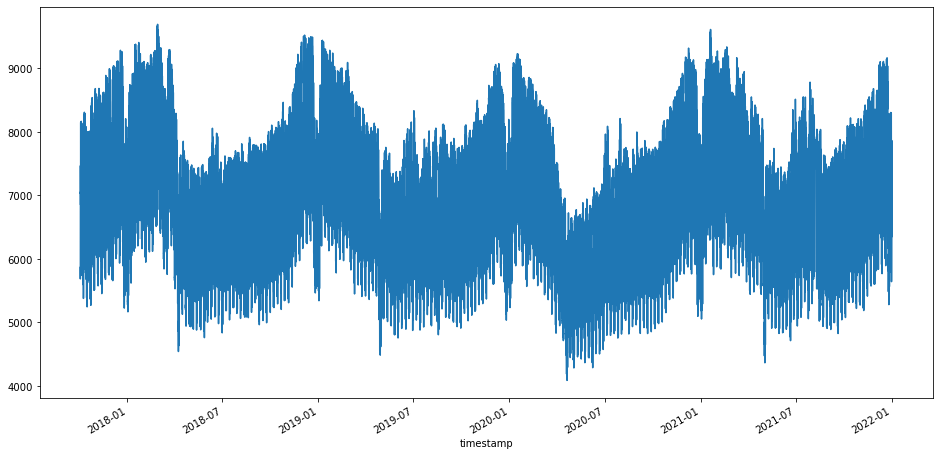

In [68]:
entsoe_meteostat_real_1["real_energy_load"].plot(figsize = (16,8))